# Lab 4: Non-negative Matrix Factorization

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD4"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L4_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [29]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from sklearn.utils       import check_random_state
from sklearn.datasets    import fetch_olivetti_faces

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds        = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

dataset          = fetch_olivetti_faces(shuffle=True)
faces            = dataset.data.T #on représente chaque image par une colonne, en accord avec le cours
faces[3523][338] = 1e-2 #l'un des éléments de faces est nul, ce qui bloque la divergence de KL

In [30]:
faces.shape

(4096, 400)

## NMF

Fill in the following NMF class:

Loss (Regularized Froebnius): $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]:

\begin{array}{c}
W \leftarrow W \circ \frac{X H^{\top}}{W (H H^{\top} + {\color{red} \nu I_r})} \\
H \leftarrow H \circ \frac{W^{\top} X - {\color{red} \lambda 1_{r \times n}}}{(W^{\top} W + {\color{red} \mu I_r})H}
\end{array}

In [31]:
#Yassine
class MYNMF():

    """ Class for logistic regression:

    Attributes:
    -----------                                                Default value
    n_components_ : integer,  unknown dimension of W and H   | 20
    max_iter_     : integer,  maximum number of iterations   | 60
    epsilon_      : float,    epsilon coefficient            | 1e-4
    loss_         : str,      {"Frobenius", "KL"}            | Frobenius
    D_            : np.array, W Matrix factor                | None
    S_            : np.array, H Matrix factor                | None
    D_history     : list,     W Matrix history               | []
    S_history     : list,     H Matrix history               | []
    loss_history  : list,     history of loss                | []
    random_state  : int,      for the random initialization  | 42
    """

    def __init__(self, n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", random_state=42):

        self.n_components_ = n_components
        self.max_iter_     = max_iter
        self.epsilon_      = epsilon
        self.loss_         = loss
        self.D_            = None
        self.S_            = None
        self.D_history     = []
        self.S_history     = []
        self.loss_history  = []
        self.random_state  = random_state
        self.components_   = None    # shape (r, p)

    def fit_transform(self, data, mu=5e-3,  nu=5e-3, lambd=1e-3):


      (p,n)=data.shape
      r=self.n_components_
      self.D_=np.random.rand(p,r)
      self.S_=np.random.rand(r,n)
      self.D_history.append(self.D_)
      self.S_history.append(self.S_)
      for i in range(self.max_iter_):
        if self.loss_=="Frobenius":
          self.D_=self.D_ * (data@self.S_.T/(self.D_@(self.S_@self.S_.T+nu*np.eye(r)))+self.epsilon_)
          self.D_ = np.maximum(self.D_,self.epsilon_)
          self.S_=self.S_ * ((self.D_.T@data-lambd*np.ones((r,n)))/((self.D_.T@self.D_+mu*np.eye(r))@self.S_+self.epsilon_))
          self.S_ = np.maximum(self.S_,self.epsilon_)
          self.D_history.append(self.D_)
          self.S_history.append(self.S_)

          self.loss_history.append(0.5*np.linalg.norm(data-self.D_@self.S_,"fro")**2+0.5*mu*np.linalg.norm(self.S_,"fro")**2+lambd*np.linalg.norm(self.S_,1)+0.5*nu*np.linalg.norm(self.D_,"fro")**2)
          self.components_ = self.D_
        elif self.loss_ == "KL":
          V_reconstruction = self.D_ @ self.S_ + self.epsilon_

          M_ratio = data / V_reconstruction
          numerator_D = M_ratio @ self.S_.T
          denominator_D = np.sum(self.S_, axis=1, keepdims=True).T
          self.D_ *= numerator_D / (denominator_D + self.epsilon_)
          self.D_ = np.maximum(self.D_, self.epsilon_)

          norms = np.sum(self.D_, axis=0, keepdims=True)
          self.D_ /= norms
          self.S_ *= norms.T

          M_ratio = data / (self.D_ @ self.S_ + self.epsilon_)
          numerator_S = self.D_.T @ M_ratio
          denominator_S = np.sum(self.D_, axis=0, keepdims=True).T
          self.S_ *= numerator_S / (denominator_S + self.epsilon_)
          self.S_ = np.maximum(self.S_, self.epsilon_)

          ratio = np.where(data > 0, data / V_reconstruction, 1)
          kl_loss = np.sum(np.where(data > 0,
                                    data * np.log(ratio) - data + V_reconstruction,
                                    V_reconstruction))
          self.loss_history.append(kl_loss)
          self.D_history.append(self.D_)
          self.S_history.append(self.S_)
          self.components_ = self.D_



    def predict_label(self, X):
        """ Predict labels for X : cluster hard-assignment

        Parameters:
        -----------
        X: (n, p) np.array, data matrix

        Returns:
        -----
        label assignment : (p, ) np.array, Its elements are the predicted classes, from 0 to r-1
        """
        if self.components_ is None:
            raise RuntimeError("The model must be fitted before predicting labels.")

        activations = X.T @ self.components_.T

        labels = np.argmax(activations, axis=1)

        return labels


    def predict_proba(self, X):
        """ Predict probabilities of different classes for X :  cluster soft-assignment

        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix

        Returns:
        -----
        label_assignment : (n, r) np.array
                          Its elements are the probabilities for different classes
        """
        if self.components_ is None:
            raise RuntimeError("The model must be fitted before predicting probabilities.")

        activations = X.T @ self.components_.T

        probabilities = np.exp(activations) / np.sum(np.exp(activations), axis=1, keepdims=True)

        return probabilities


## Hyperparameter optimization

### Regularization parameter : mu

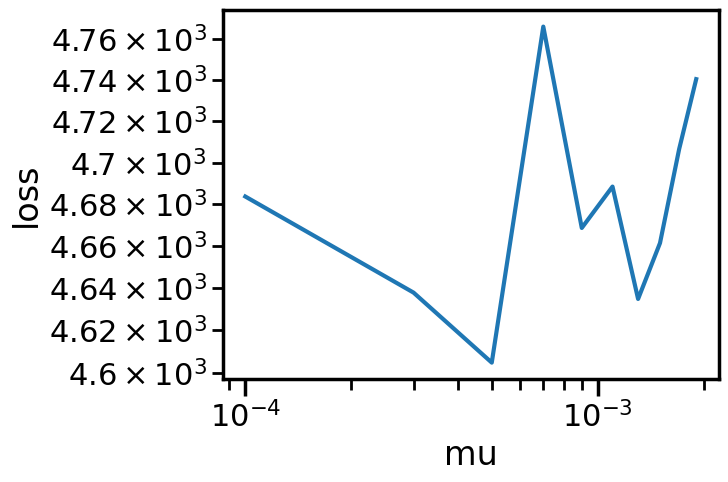

In [32]:
#TODO : find best mu

mu = [0.0001 + i*0.0002 for i in range (10)]
loss_history = []
for m in mu:
  nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", random_state=42)
  nmf.fit_transform(faces, mu=m,  nu=5e-3, lambd=1e-3)
  loss_history.append(nmf.loss_history[-1])

import matplotlib.pyplot as plt
plt.plot(mu, loss_history)
plt.xlabel('mu')
plt.ylabel('loss')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [33]:
best_mu = mu[np.argmin(loss_history)]
best_mu

0.0005

### Regularization parameter : nu

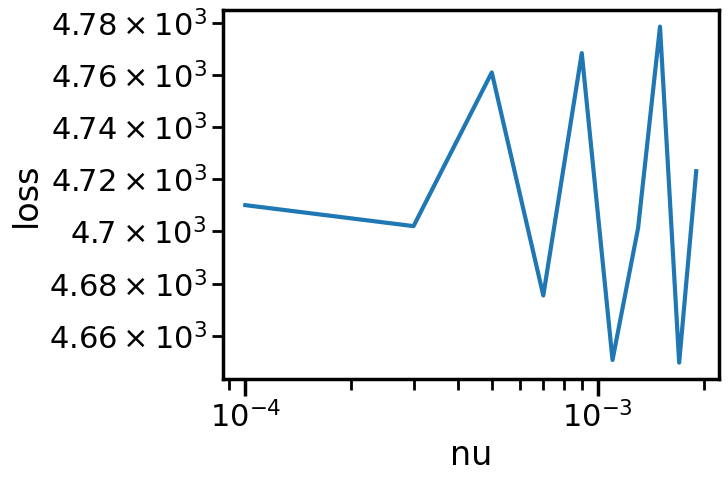

In [34]:
#TODO : find best nu

nu = [0.0001 + i*0.0002 for i in range (10)]
loss_history = []
for n in nu:
  nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", random_state=42)
  nmf.fit_transform(faces,  nu=n, lambd=1e-3,mu = best_mu)
  loss_history.append(nmf.loss_history[-1])

import matplotlib.pyplot as plt
plt.plot(nu, loss_history)
plt.xlabel('nu')
plt.ylabel('loss')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [35]:
best_nu = nu[np.argmin(loss_history)]
best_nu

0.0017000000000000001

### Regularization parameter : lambda

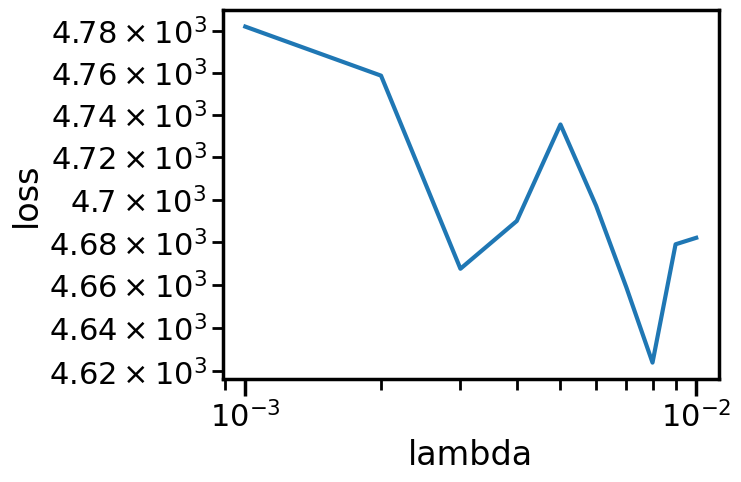

In [36]:
#TODO : find best lambda

lambdas = [0.001 + i*0.001 for i in range (10)]
loss_history = []
for lambd in lambdas:
  nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", random_state=42)
  nmf.fit_transform(faces, lambd=lambd, nu=best_nu,mu = best_mu)
  loss_history.append(nmf.loss_history[-1])

import matplotlib.pyplot as plt
plt.plot(lambdas, loss_history)
plt.xlabel('lambda')
plt.ylabel('loss')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [37]:
best_lambda = lambdas[np.argmin(loss_history)]
best_lambda

0.008

Reconstructed data shape: (4096, 400)


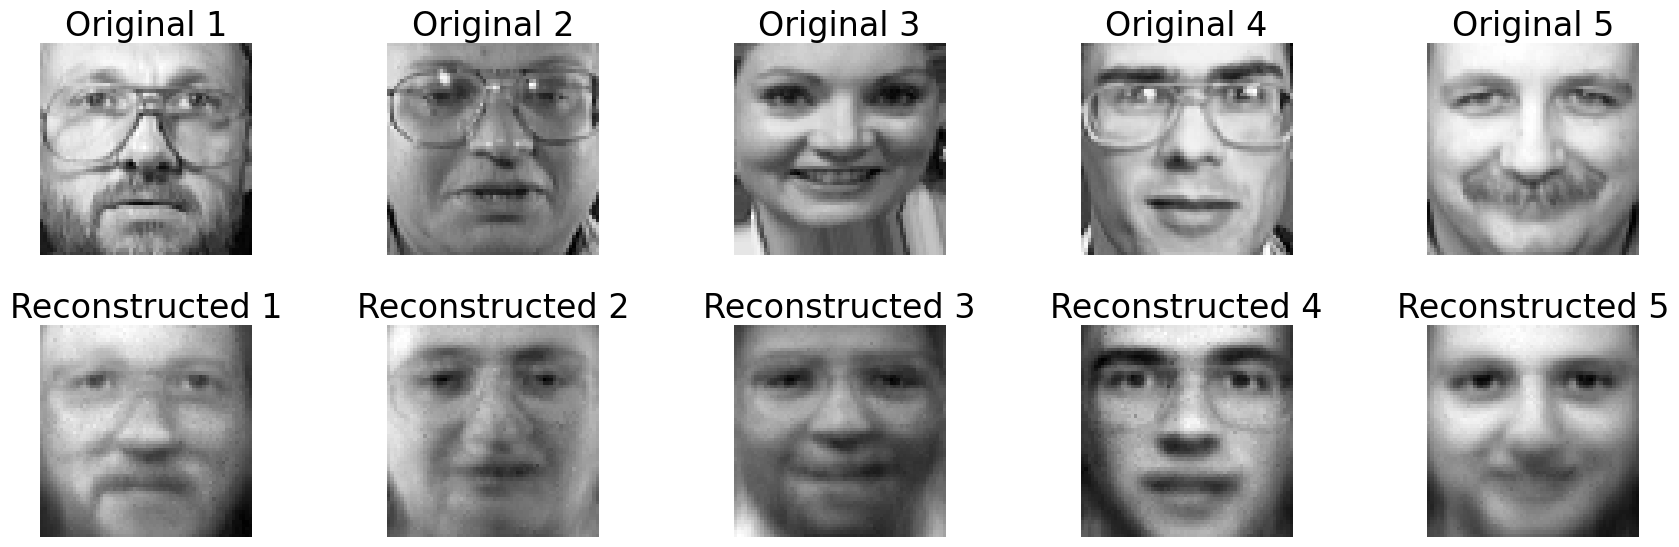

In [38]:
#TODO : check results for mu, nu and lambda with new obtained regularization parameters
nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", random_state=42)
nmf.fit_transform(faces, mu=best_mu,  nu=best_nu, lambd=best_lambda)
h, w = 64,64
num_images_to_plot = 5
reconstructed_data = nmf.D_ @ nmf.S_
p, n = reconstructed_data.shape
print(f"Reconstructed data shape: {reconstructed_data.shape}")
fig, axes = plt.subplots(2, num_images_to_plot, figsize=(18, 6))

for i in range(num_images_to_plot):
    reconstructed_image = reconstructed_data[:, i].reshape((h, w))
    original_image = faces[:, i].reshape((h, w))

    #plot original Image
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    # Plot Reconstructed Image
    axes[1, i].imshow(reconstructed_image, cmap='gray')
    axes[1, i].set_title(f"Reconstructed {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Number of components

We are going to determine the **optimal number of components** for the factorization by plotting the final loss after 100 epochs for different number of components.
We expect an **elbow curve**, and we will choose the value at the elbow point. Indeed, the higher the number of components is, the more precise the atoms of the dictionary can be, and thus the more precise the reconstructed image will be.
We will find the optimal parameter both for Frobenius and Kullback-Leibler distances.

#### Case of Frobenius distance

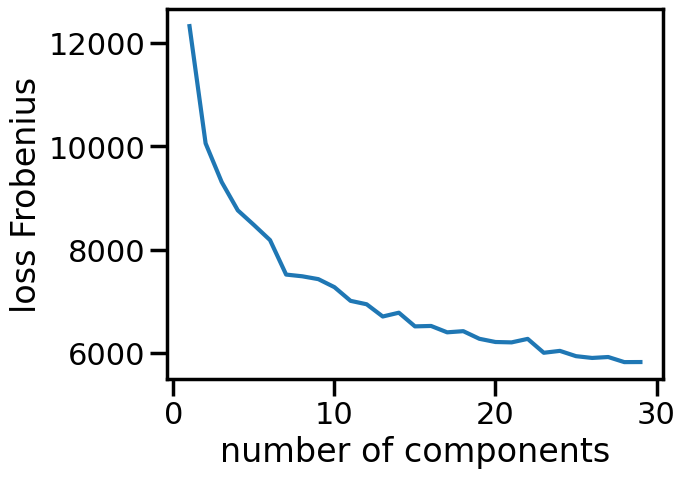

In [39]:
#TODO
number_of_components = [i for i in range (1,30)]
loss_list = []
for n_comp in number_of_components:
  nmf = MYNMF(n_components=n_comp, max_iter=100, epsilon = 1e-5, loss = "Frobenius", random_state=42)
  nmf.fit_transform(faces, mu=best_mu,  nu=best_nu, lambd=best_lambda)
  loss_list.append(nmf.loss_history[-1])

import matplotlib.pyplot as plt
plt.plot(number_of_components, loss_list)
plt.xlabel('number of components')
plt.ylabel('loss Frobenius')
plt.show()


#### Case of Kullback-Leibler divergence

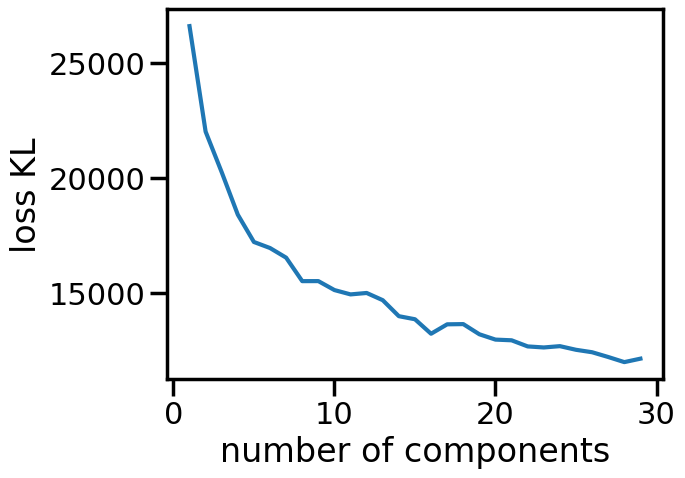

In [40]:
#TODO
number_of_components = [i for i in range (1,30)]
loss_list = []
for n_comp in number_of_components:
  nmf = MYNMF(n_components=n_comp, max_iter=100, epsilon = 1e-5, loss = "KL", random_state=42)
  nmf.fit_transform(faces, mu=best_mu,  nu=best_nu, lambd=best_lambda)
  loss_list.append(nmf.loss_history[-1])

import matplotlib.pyplot as plt
plt.plot(number_of_components, loss_list)
plt.xlabel('number of components')
plt.ylabel('loss KL')
plt.show()

## Comparison between the two distances

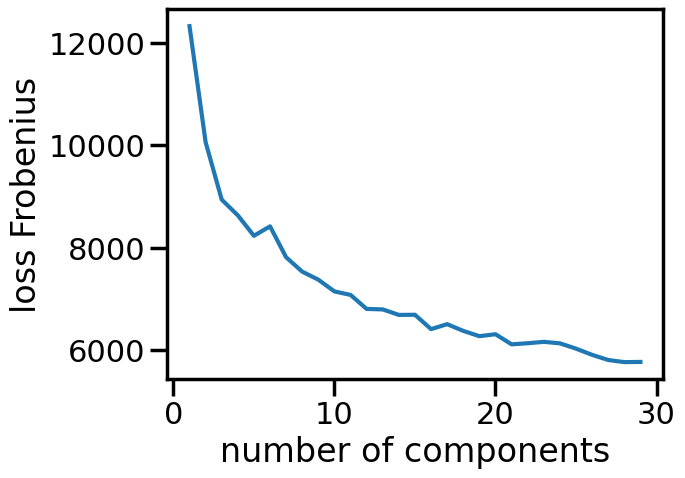

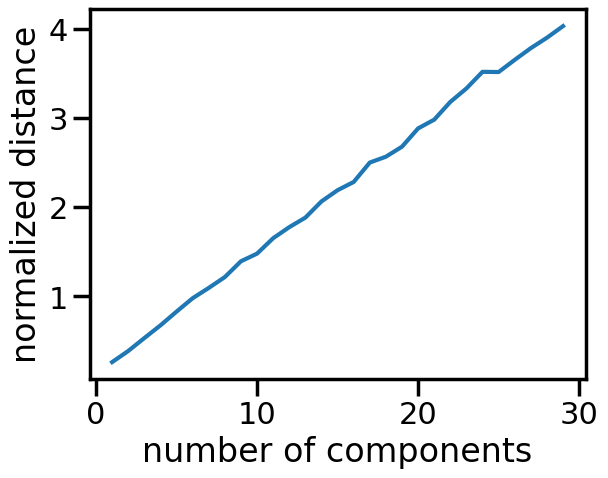

In [41]:
#TODO : plot the loss and normalized distances between S and D for different number of components

number_of_components = [i for i in range (1,30)]
loss_list = []
distance_list = []
for n_comp in number_of_components:
  nmf = MYNMF(n_components=n_comp, max_iter=100, epsilon = 1e-5, loss = "Frobenius", random_state=42)
  nmf.fit_transform(faces, mu=best_mu,  nu=best_nu, lambd=best_lambda)
  loss_list.append(nmf.loss_history[-1])
  distance_list.append(np.linalg.norm(nmf.S_,"fro")/np.linalg.norm(nmf.D_,"fro"))

import matplotlib.pyplot as plt
plt.plot(number_of_components, loss_list)
plt.xlabel('number of components')
plt.ylabel('loss Frobenius')
plt.show()

plt.plot(number_of_components, distance_list)
plt.xlabel('number of components')
plt.ylabel('normalized distance')
plt.show()

## Model training

### Training with Frobenius distance for different number of components

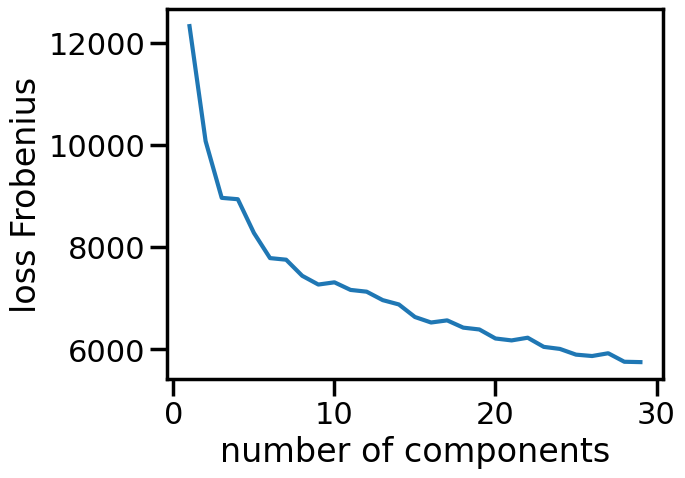

In [42]:
#TODO : Train different models for different number of components with Frobenius loss and plot loss function
number_of_components = [i for i in range (1,30)]
loss_list = []
models_frob = []
for n_comp in number_of_components:
  nmf = MYNMF(n_components=n_comp, max_iter=100, epsilon = 1e-5, loss = "Frobenius", random_state=42)
  nmf.fit_transform(faces, mu=best_mu,  nu=best_nu, lambd=best_lambda)
  loss_list.append(nmf.loss_history[-1])
  models_frob.append(nmf)

import matplotlib.pyplot as plt
plt.plot(number_of_components, loss_list)
plt.xlabel('number of components')
plt.ylabel('loss Frobenius')
plt.show()

### Training with KL-divergence for different number of components

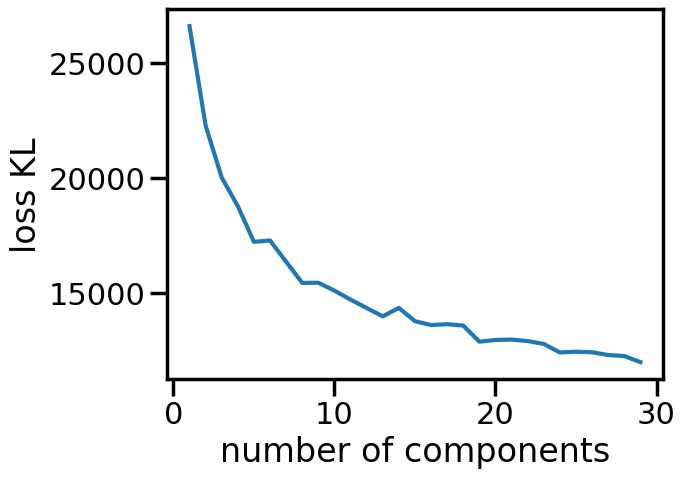

In [43]:
#TODO : Train different models for different number of components with KL divergence and plot loss function
number_of_components = [i for i in range (1,30)]
loss_list = []
models_kl = []
for n_comp in number_of_components:
  nmf = MYNMF(n_components=n_comp, max_iter=100, epsilon = 1e-5, loss = "KL", random_state=42)
  nmf.fit_transform(faces, mu=best_mu,  nu=best_nu, lambd=best_lambda)
  loss_list.append(nmf.loss_history[-1])
  models_kl.append(nmf)

import matplotlib.pyplot as plt
plt.plot(number_of_components, loss_list)
plt.xlabel('number of components')
plt.ylabel('loss KL')
plt.show()

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

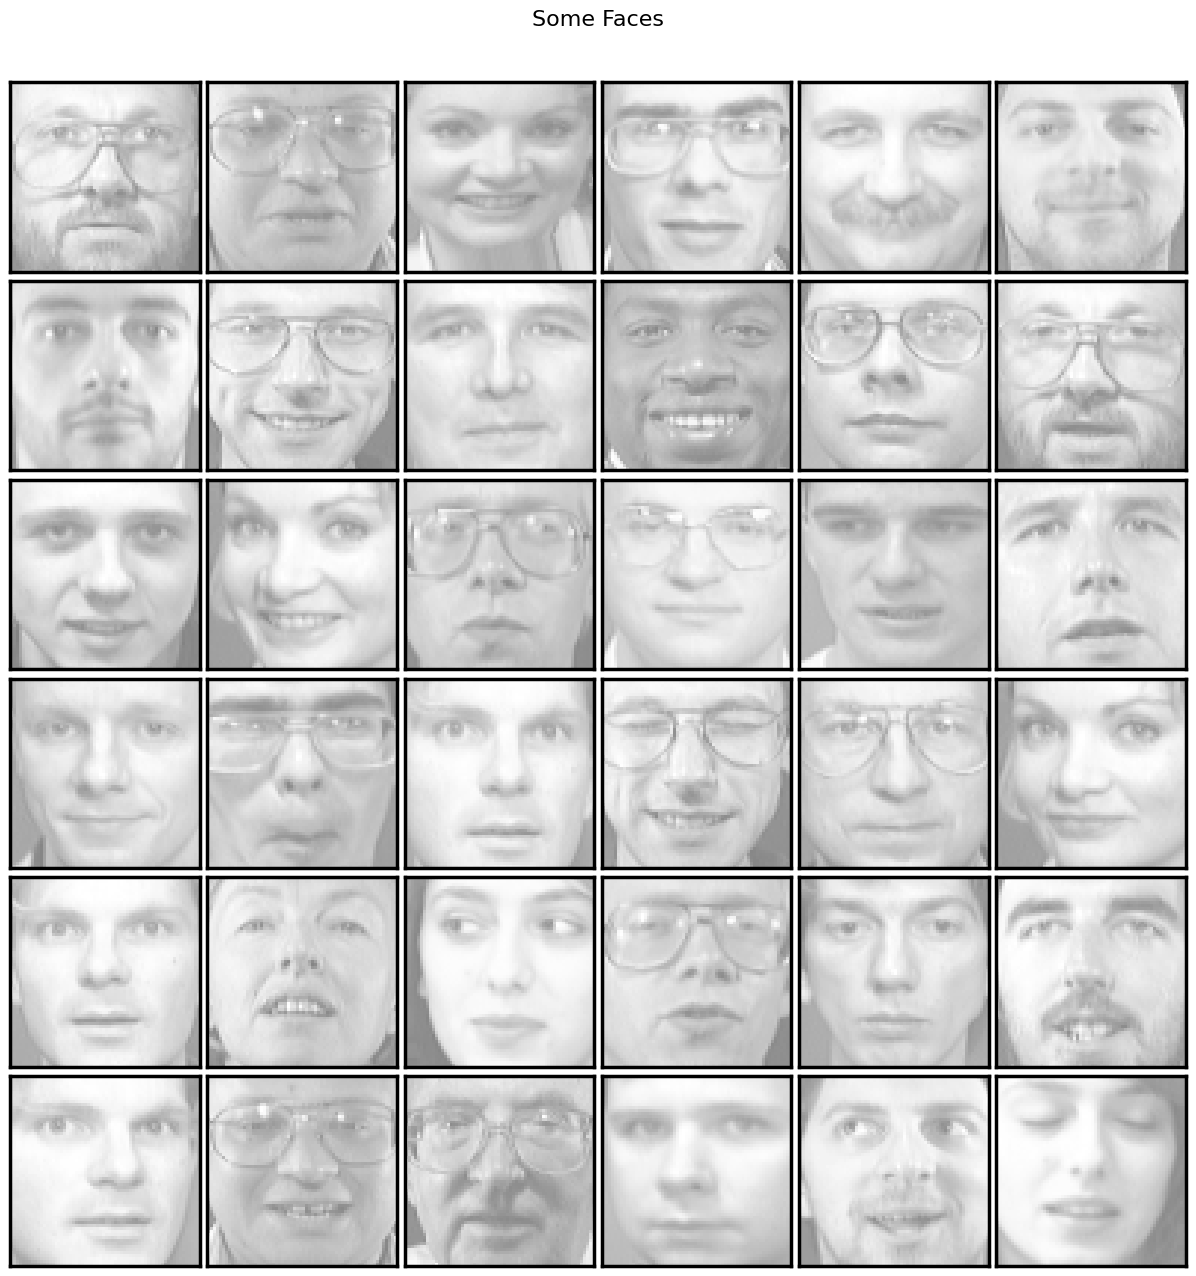

In [44]:
faces = faces.T  # n = 400 flattened images of p = 4096 = 64 x 64
image_shape = (64, 64)
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

def plot_gallery(images, image_shape, nrow, ncol, title='', cmap=plt.cm.gray):

    # fit the nb of images into a square
    n_images = len(images)
    nrows = nrow
    ncols = ncol

    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)

    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]

    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())

    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle

plot_gallery(title="Some Faces",
             images=faces[:36],
             image_shape=image_shape,nrow=6,ncol=6)


### Analysis of the number of components on the reconstruction

#### Reconstruction with Frobenius distance

Reconstructed data shape: (4096, 400)


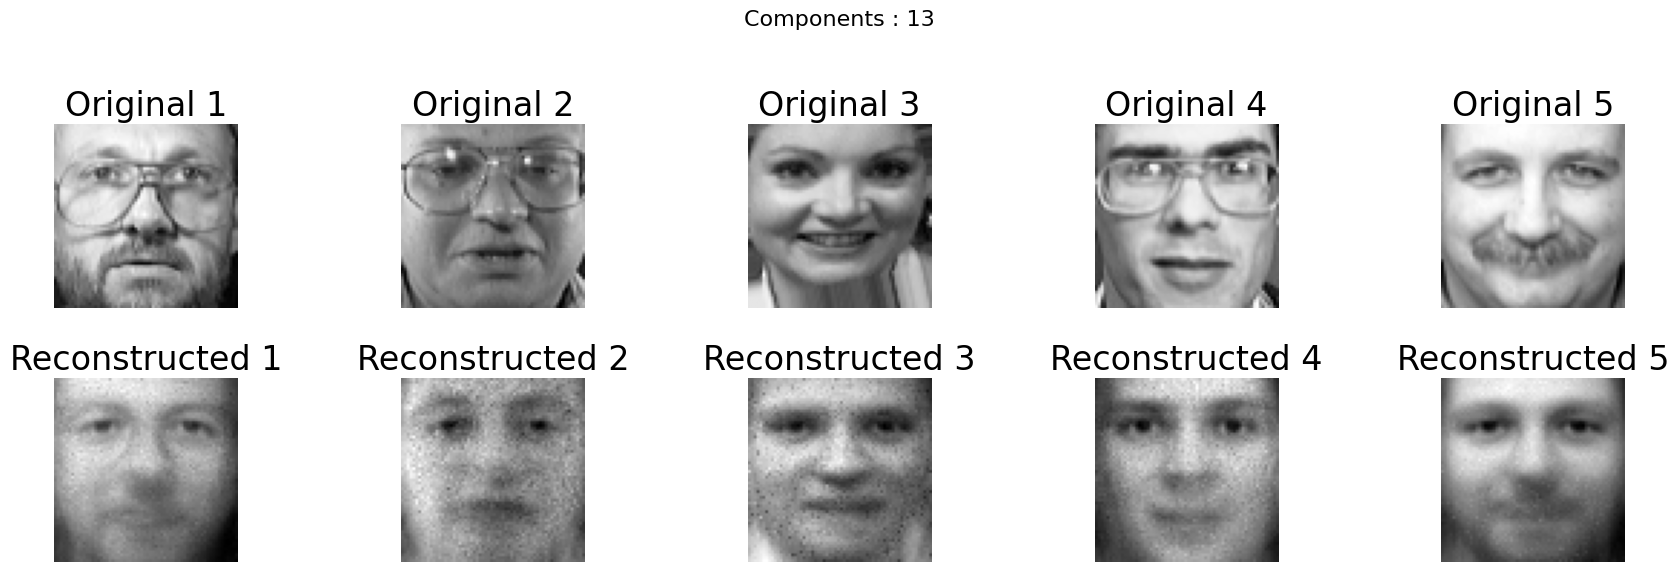

Reconstructed data shape: (4096, 400)


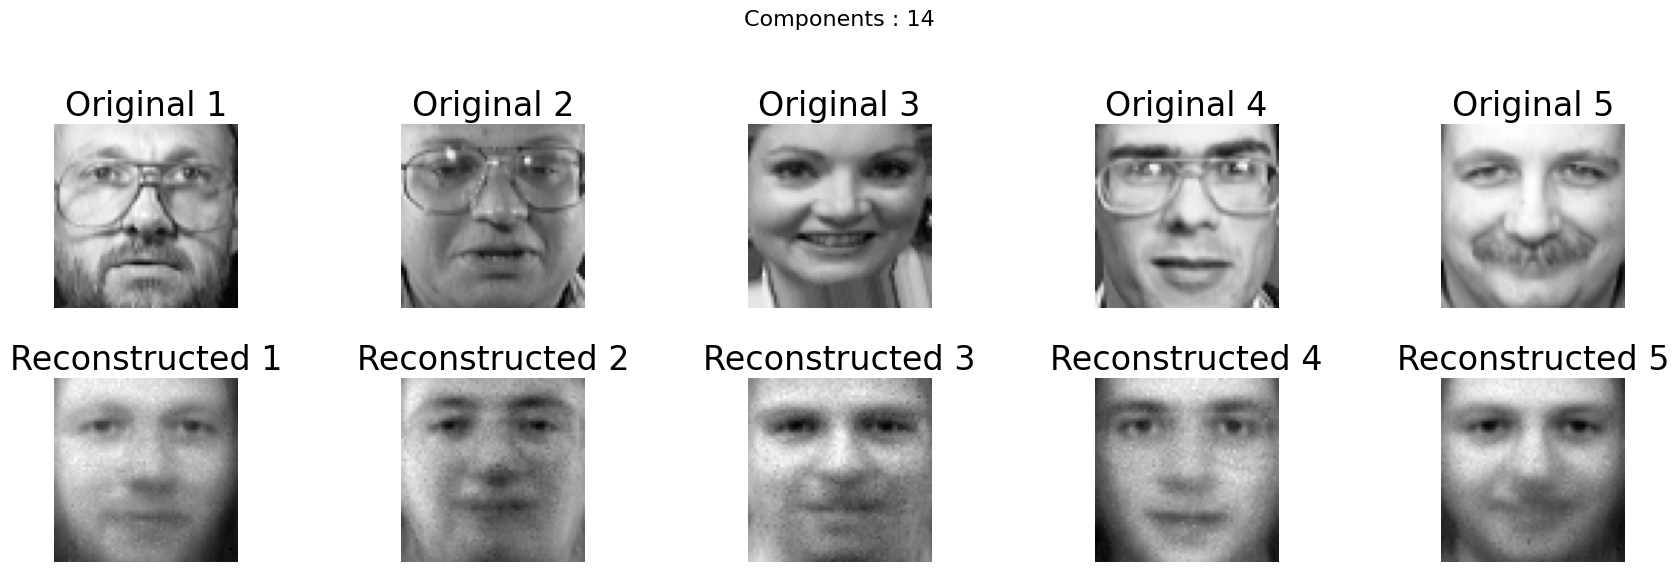

Reconstructed data shape: (4096, 400)


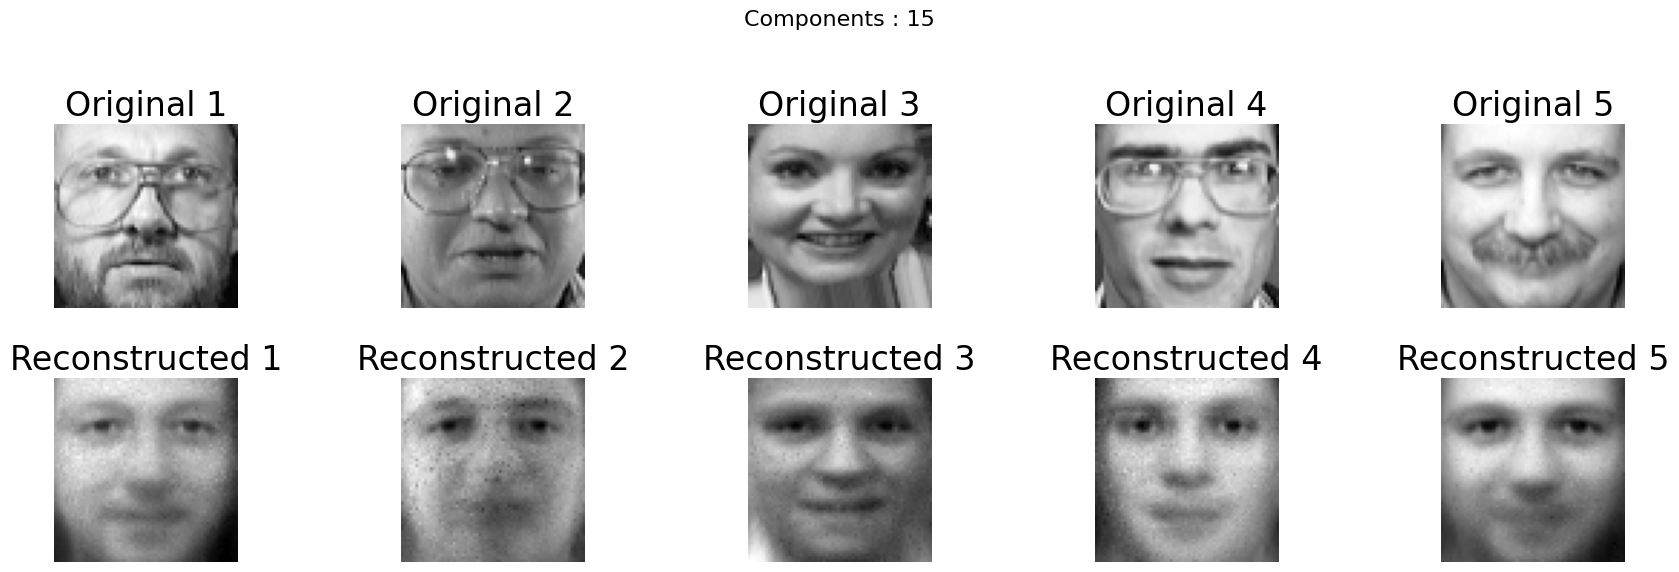

Reconstructed data shape: (4096, 400)


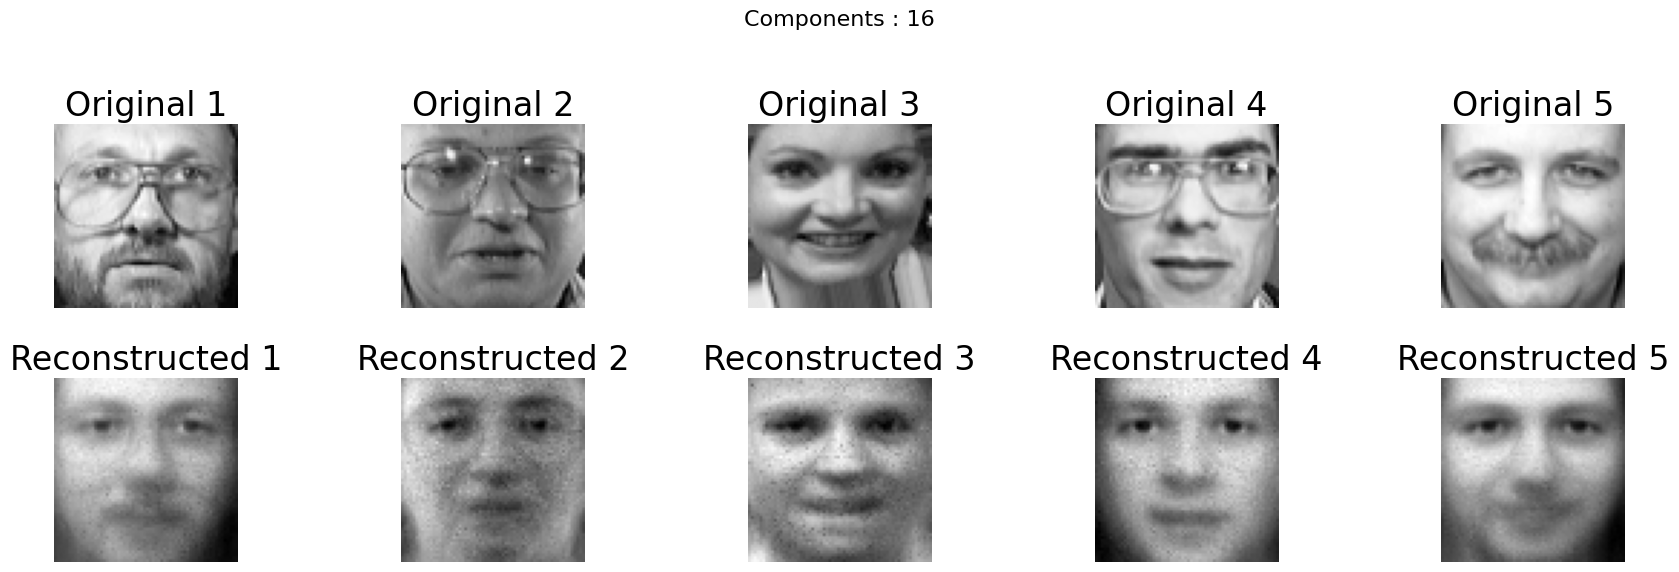

Reconstructed data shape: (4096, 400)


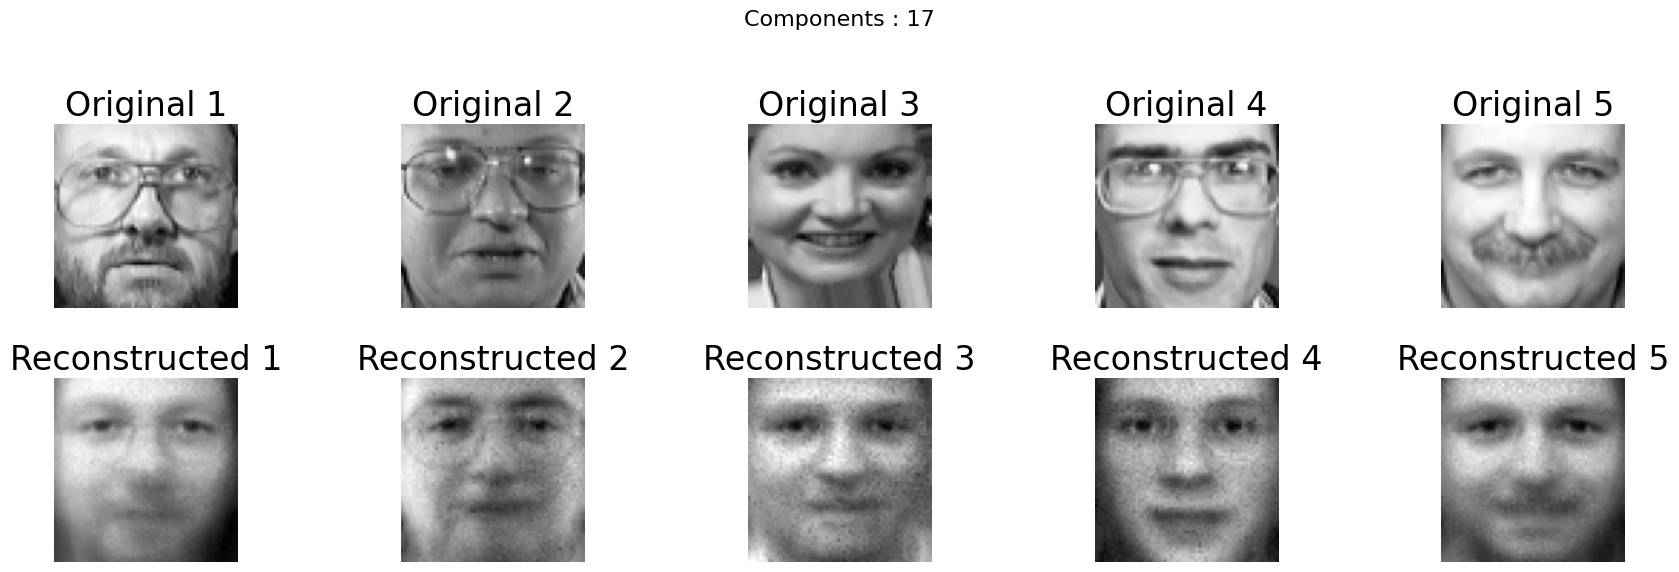

In [45]:
#TODO : plot reconstructed faces for different number of components with Frobenius distance

components = [13,14,15,16,17]
for component in components:
  nmf = models_frob[component]

  h, w = 64,64
  num_images_to_plot = 5
  reconstructed_data = nmf.D_ @ nmf.S_
  p, n = reconstructed_data.shape
  print(f"Reconstructed data shape: {reconstructed_data.shape}")
  fig, axes = plt.subplots(2, num_images_to_plot, figsize=(18, 6))

  for i in range(num_images_to_plot):
      reconstructed_image = reconstructed_data[:, i].reshape((h, w))
      original_image = faces[i, :].reshape((h, w))

      #plot original Image
      axes[0, i].imshow(original_image, cmap='gray')
      axes[0, i].set_title(f"Original {i+1}")
      axes[0, i].axis('off')

      # Plot Reconstructed Image
      axes[1, i].imshow(reconstructed_image, cmap='gray')
      axes[1, i].set_title(f"Reconstructed {i+1}")
      axes[1, i].axis('off')
  fig.suptitle(f"Components : {component}", fontsize=16)
  plt.tight_layout()
  plt.show()

#### Reconstruction with Kullback-Leibler divergence

Reconstructed data shape: (4096, 400)


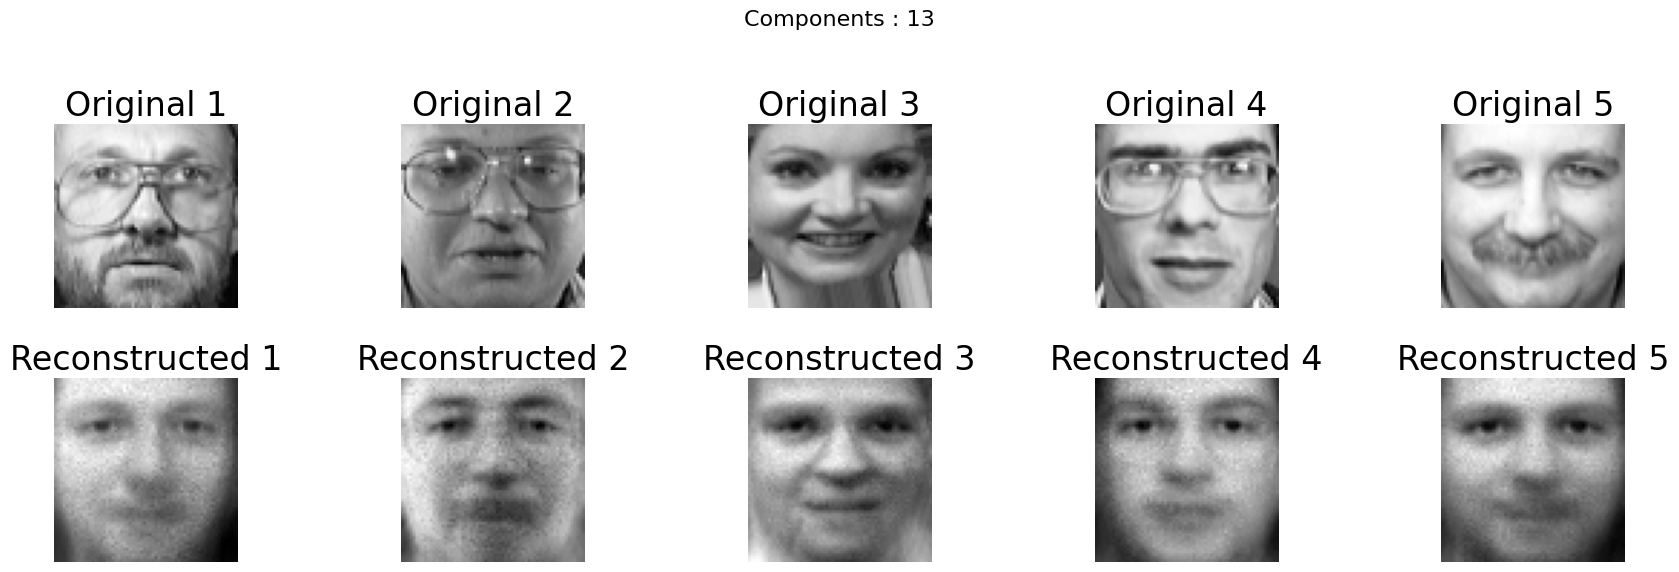

Reconstructed data shape: (4096, 400)


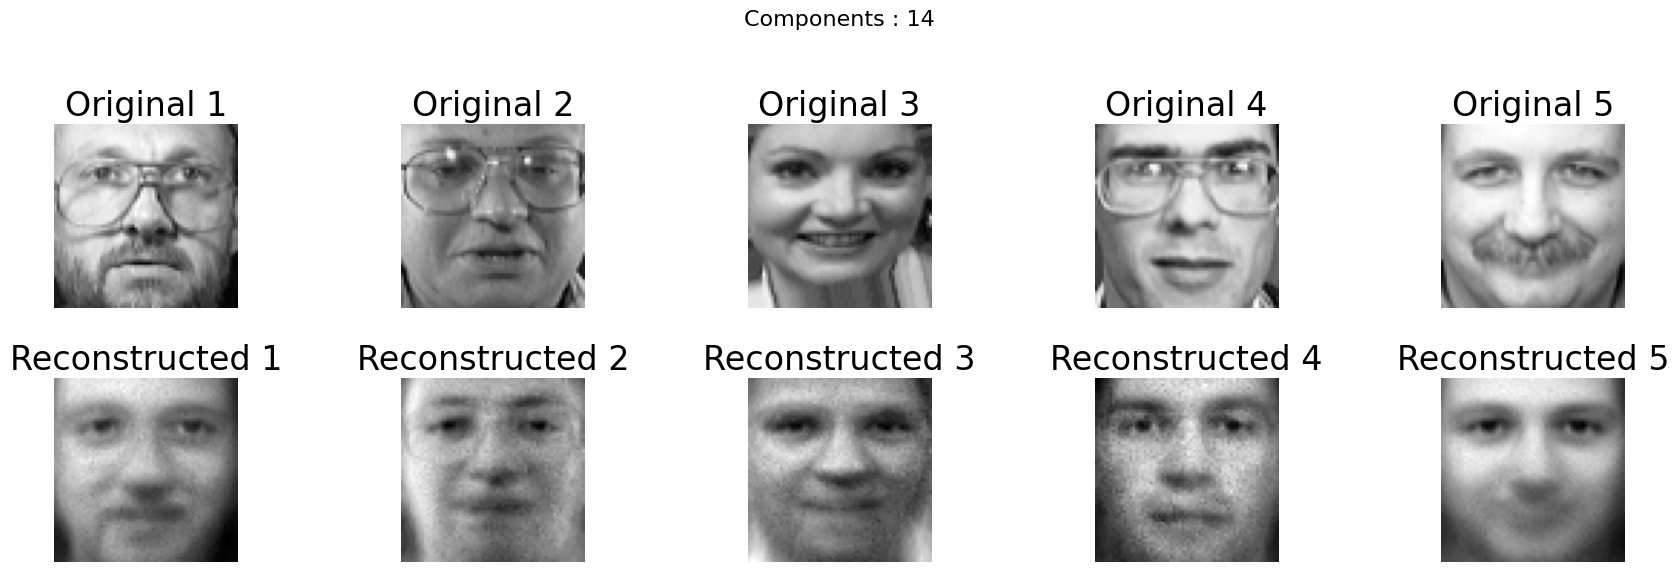

Reconstructed data shape: (4096, 400)


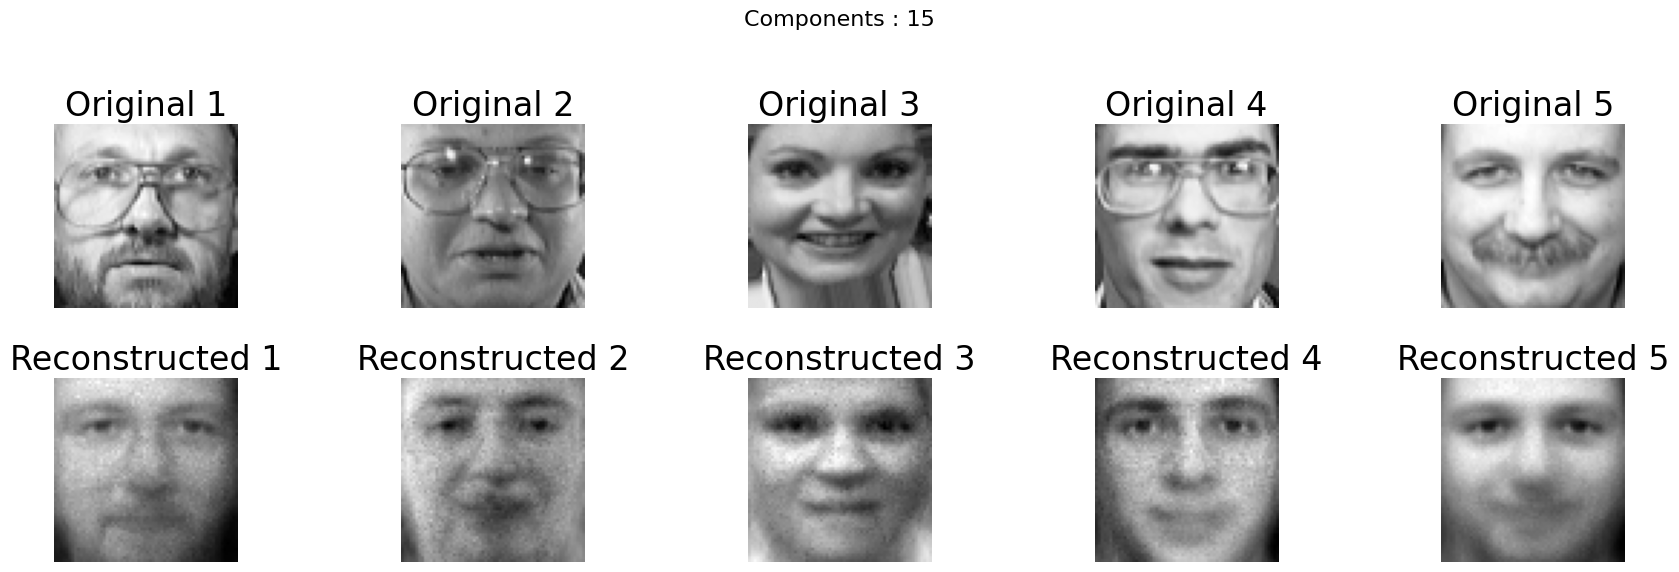

Reconstructed data shape: (4096, 400)


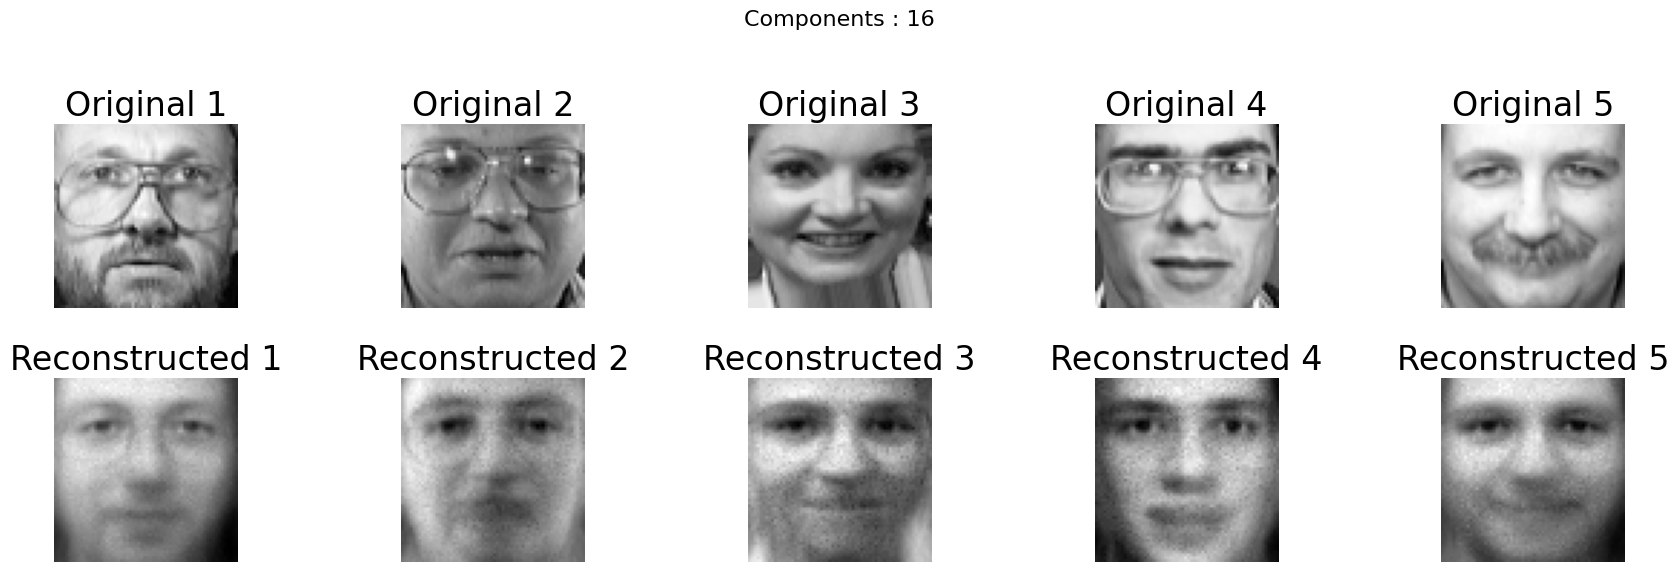

Reconstructed data shape: (4096, 400)


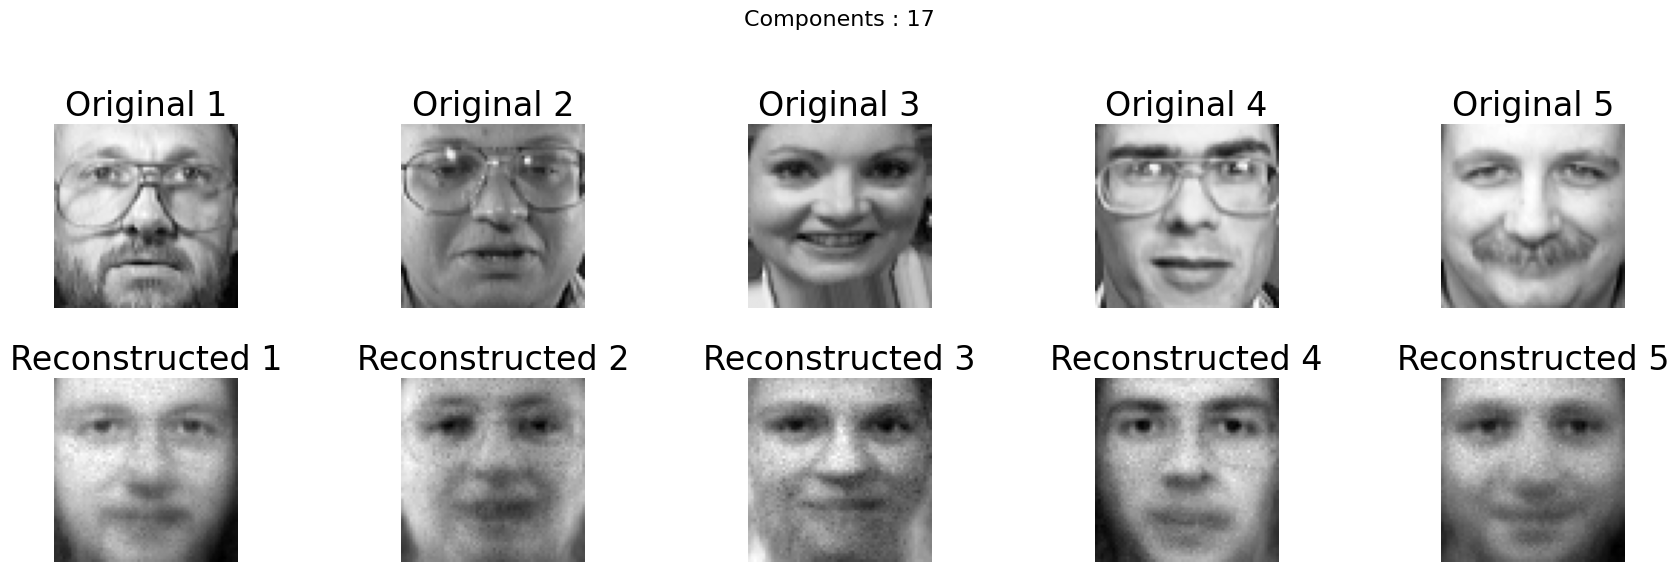

In [46]:
#TODO : plot reconstructed faces for different number of components with KL divergence

components = [13,14,15,16,17]
for component in components:
  nmf = models_kl[component]

  h, w = 64,64
  num_images_to_plot = 5
  reconstructed_data = nmf.D_ @ nmf.S_
  p, n = reconstructed_data.shape
  print(f"Reconstructed data shape: {reconstructed_data.shape}")
  fig, axes = plt.subplots(2, num_images_to_plot, figsize=(18, 6))

  for i in range(num_images_to_plot):
      reconstructed_image = reconstructed_data[:, i].reshape((h, w))
      original_image = faces[i, :].reshape((h, w))

      #plot original Image
      axes[0, i].imshow(original_image, cmap='gray')
      axes[0, i].set_title(f"Original {i+1}")
      axes[0, i].axis('off')

      # Plot Reconstructed Image
      axes[1, i].imshow(reconstructed_image, cmap='gray')
      axes[1, i].set_title(f"Reconstructed {i+1}")
      axes[1, i].axis('off')
  fig.suptitle(f"Components : {component}", fontsize=16)

  plt.tight_layout()
  plt.show()

#### Comparison of the elements of the dictionary between the two distances

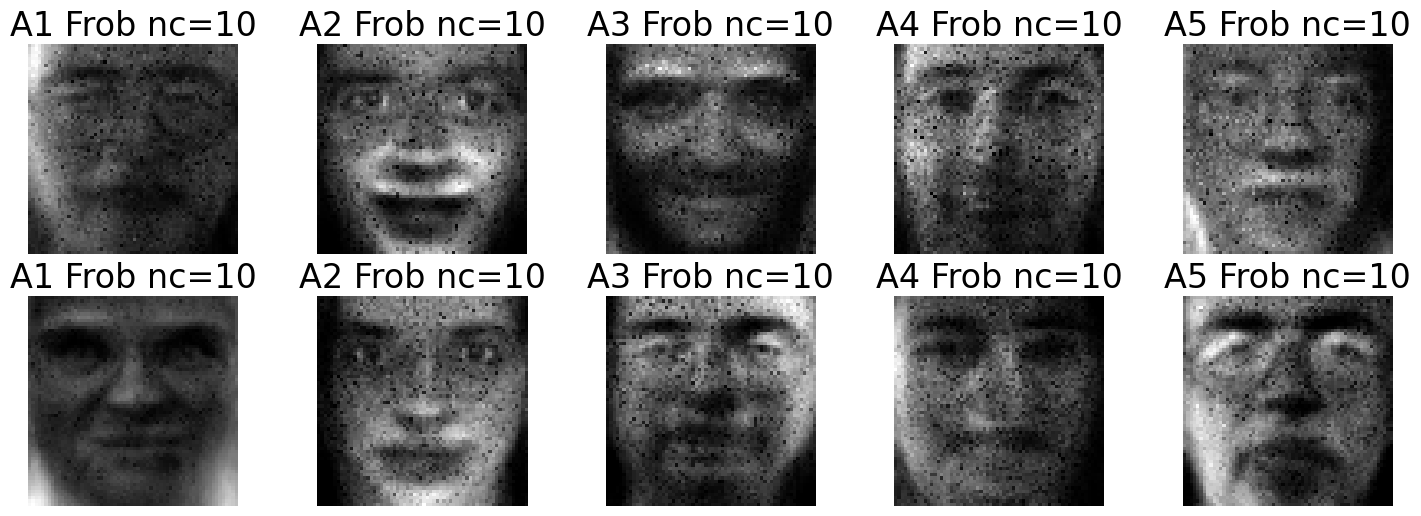

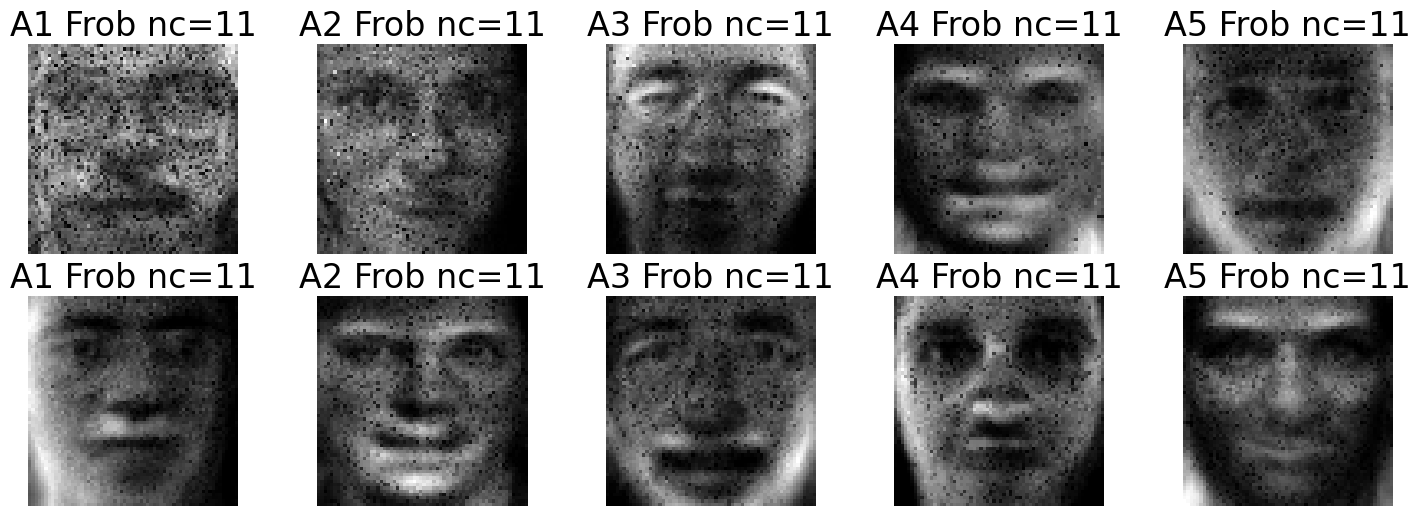

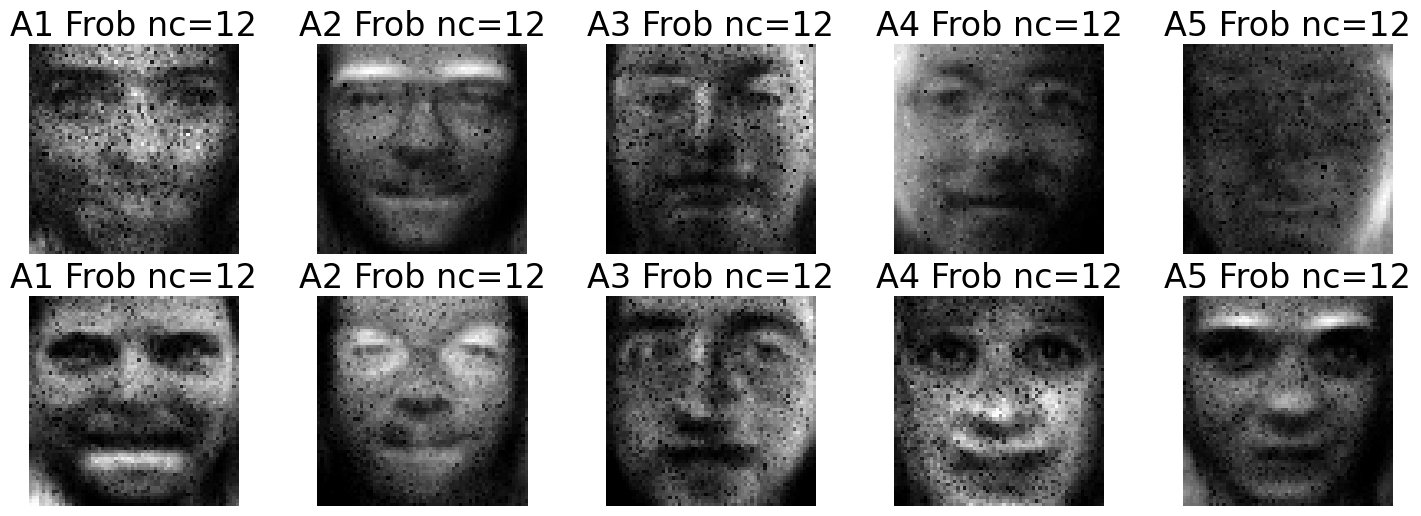

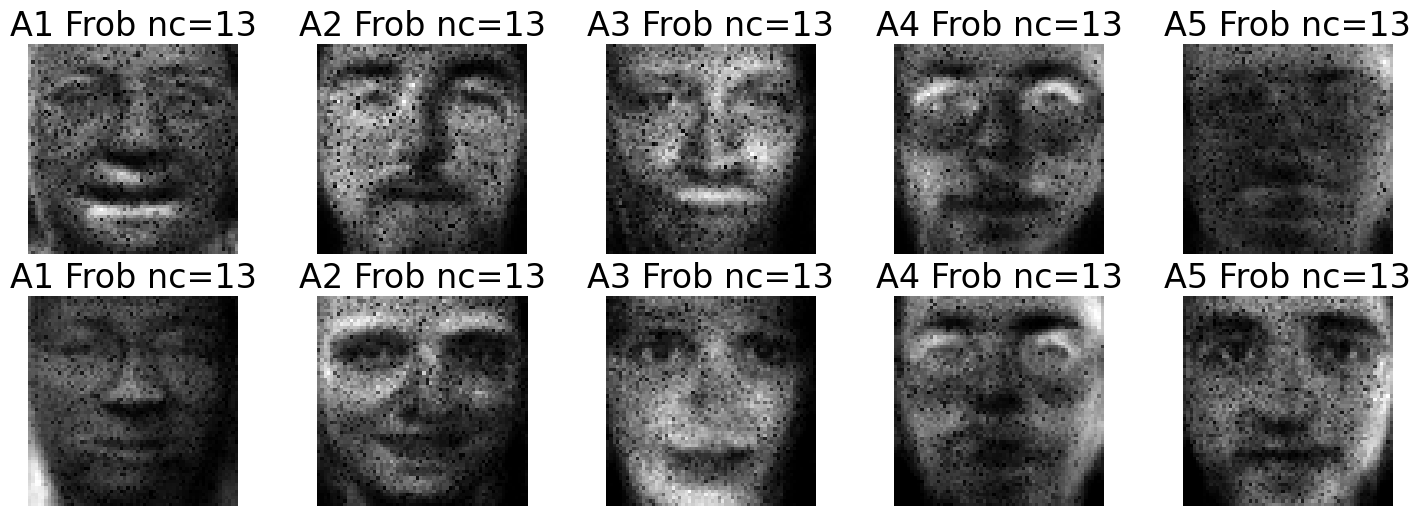

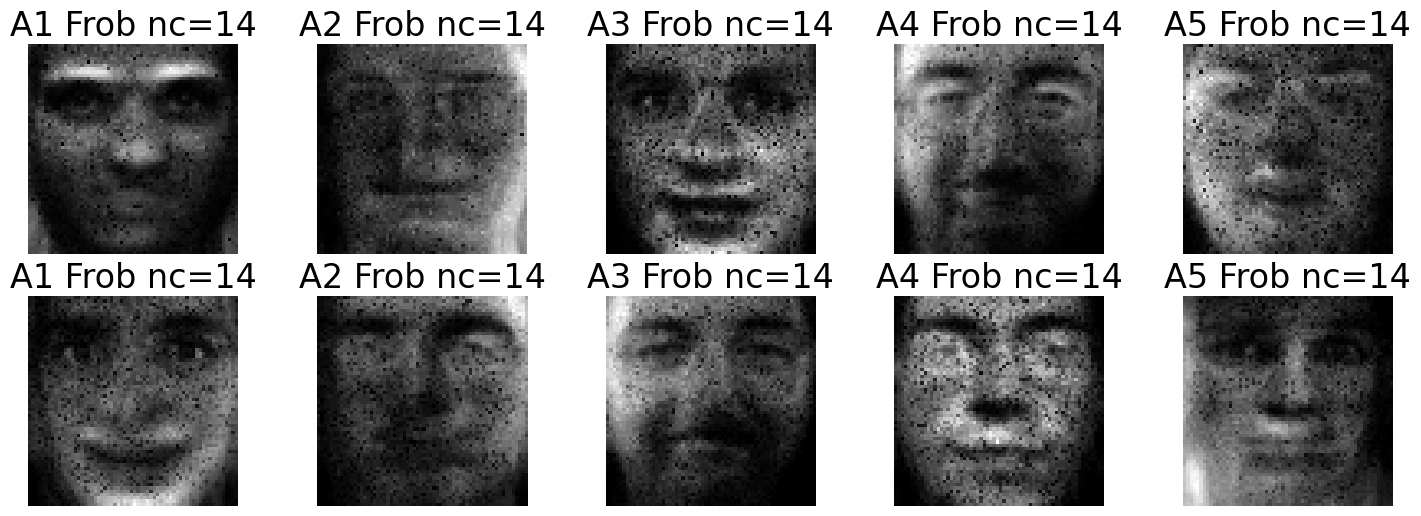

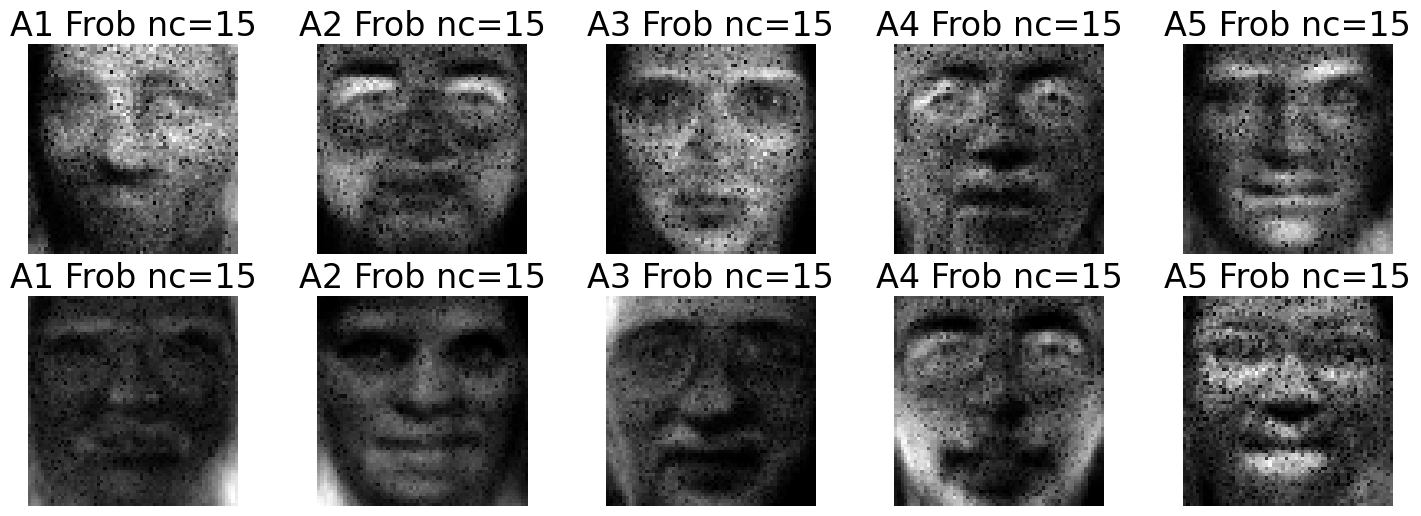

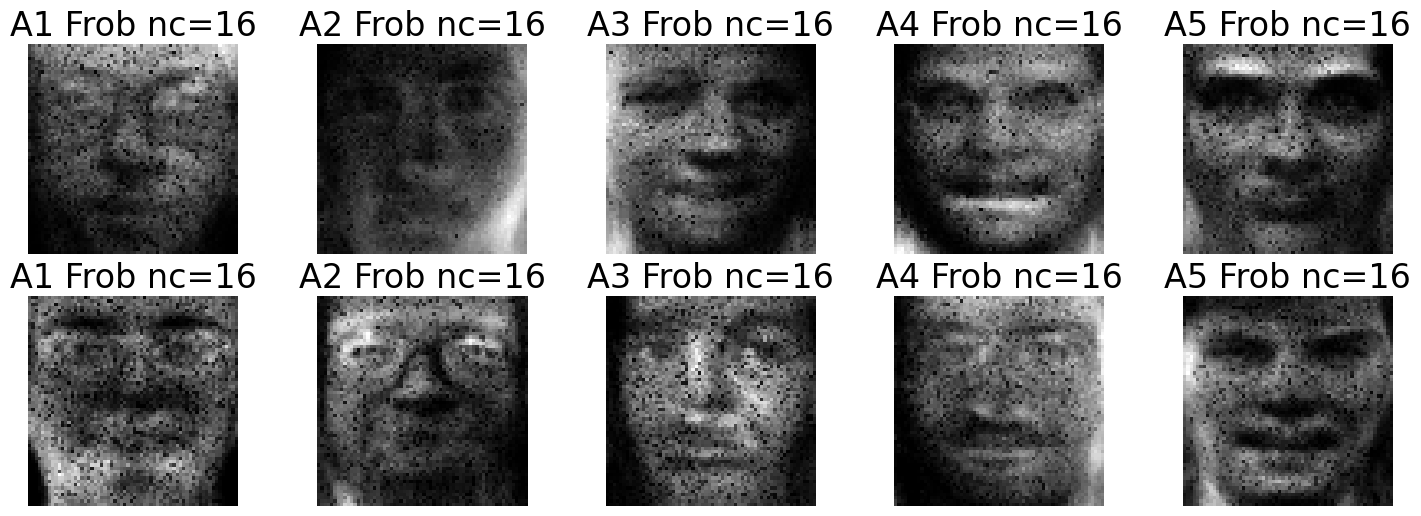

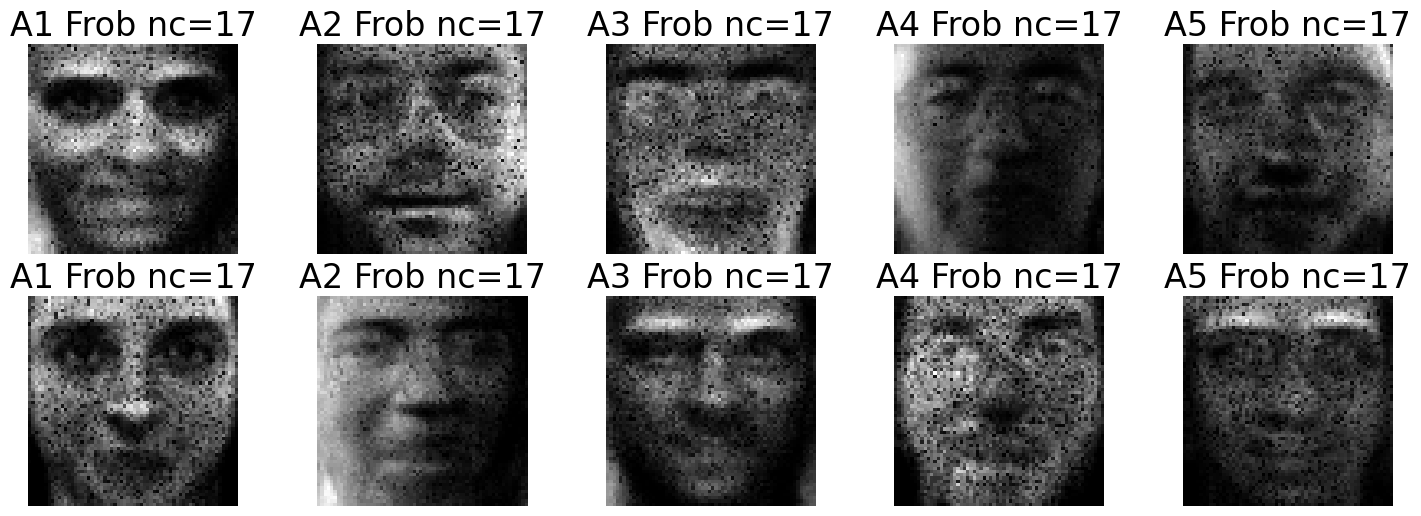

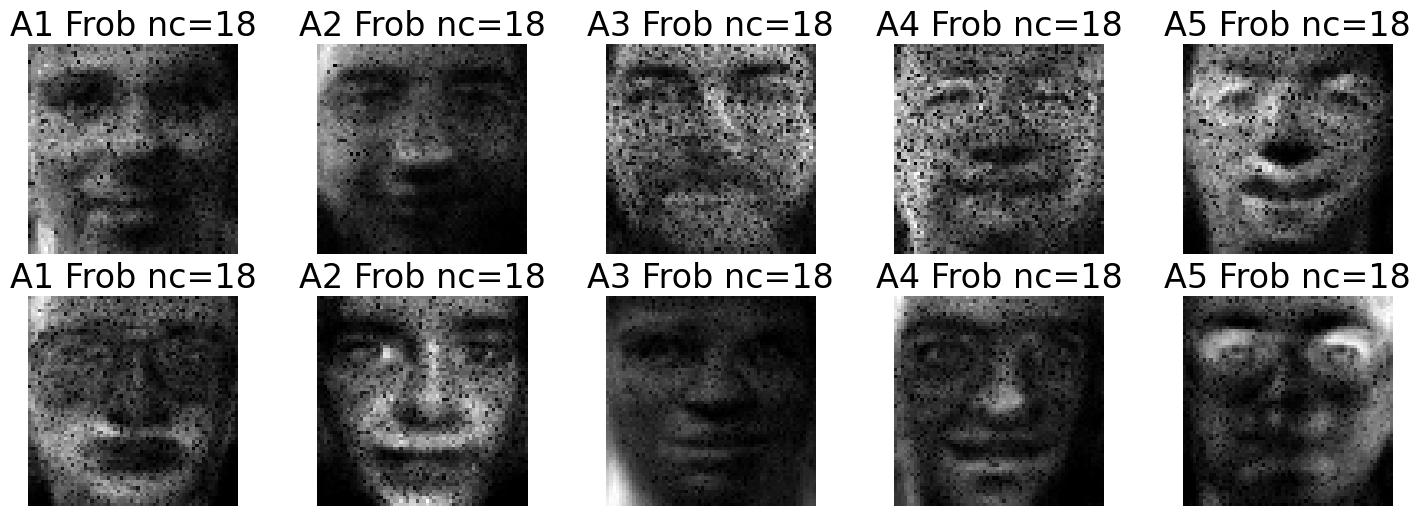

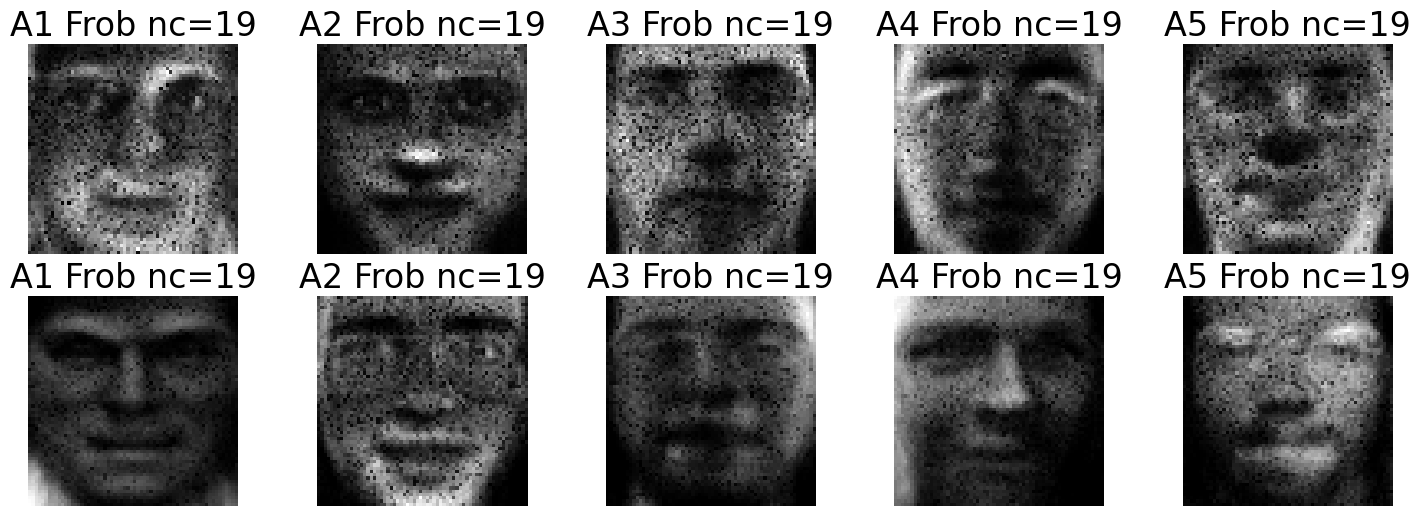

In [47]:
#TODO : plot the atoms of the dictionary for various number of components
n_atoms = 5
selected_number_of_components = [i for i in range (10,20)]
for n_comp in selected_number_of_components:
  fig, axes = plt.subplots(2, n_atoms, figsize=(18, 6))

  for i in range(n_atoms):
      nmf = models_frob[n_comp]
      h, w = 64,64
      dictionary = nmf.D_
      atom = dictionary[:, i].reshape((h, w))
      axes[0,i].imshow(atom, cmap='gray')
      axes[0,i].set_title(f"A{i+1} Frob nc={n_comp}")
      axes[0,i].axis('off')


      nmf = models_kl[n_comp]
      h, w = 64,64
      dictionary = nmf.D_
      atom = dictionary[:, i].reshape((h, w))
      axes[1,i].imshow(atom, cmap='gray')
      axes[1,i].set_title(f"A{i+1} Frob nc={n_comp}")
      axes[1,i].axis('off')



### Study of the clustering for the Frobenius distance with 30 components

Now, we are going to clusterise the images in r different classes. First, we start by normalizing the norm of the dictionary elements, so that the euclidian norm = 1, and we multiply the associated row in the S matrix to preserve the factorization DS = X. Then, we find the highest coefficient for each image, and we use the index of the maximum as clustering label.

/tmp/ipython-input-1229157826.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, min(5,len(example_idx)), figsize=(15, 3))


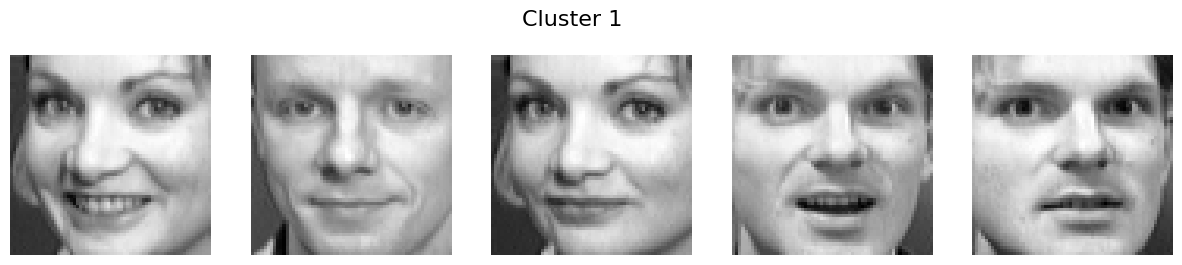

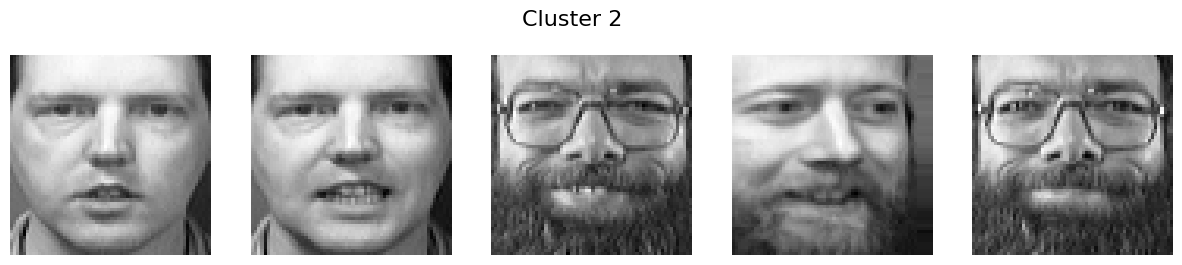

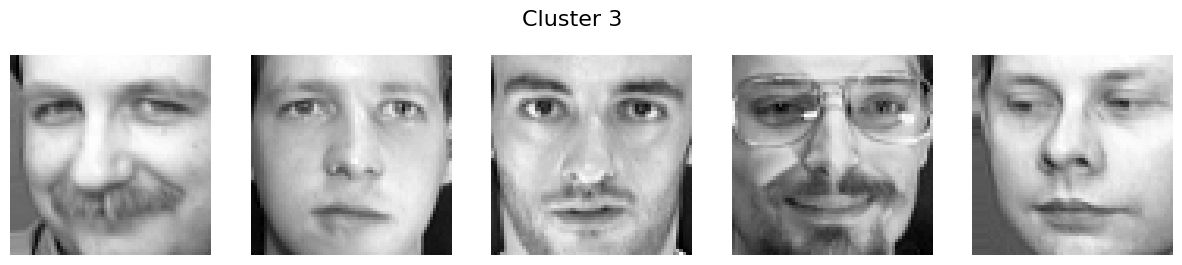

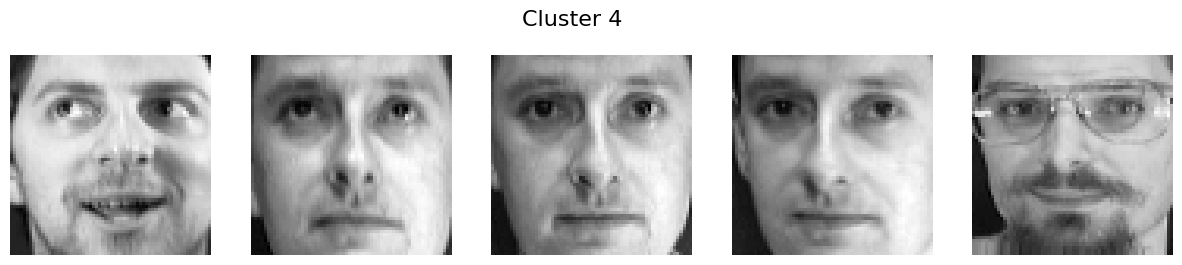

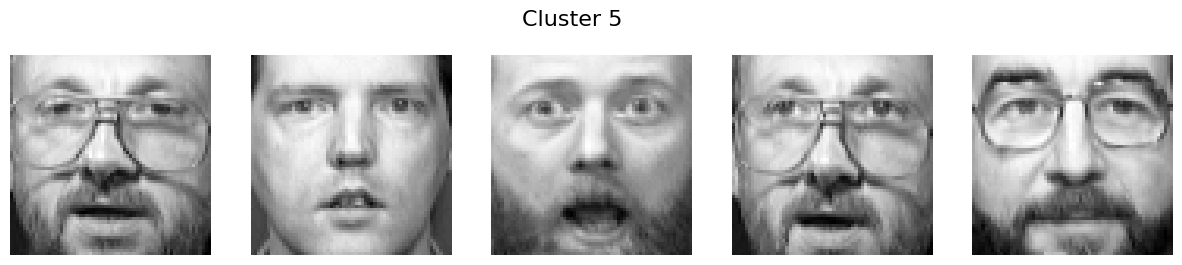

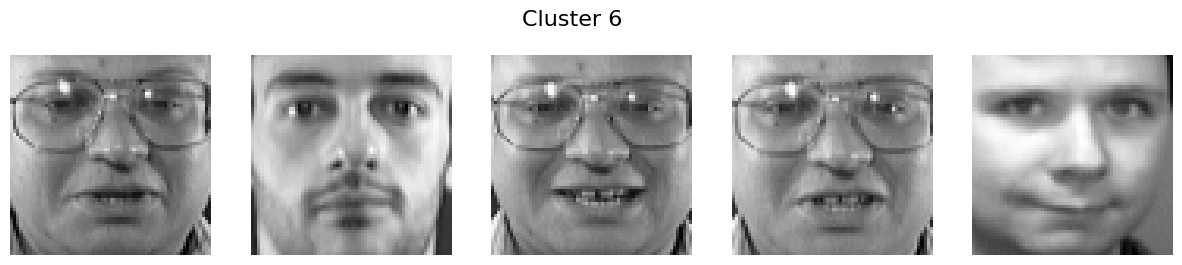

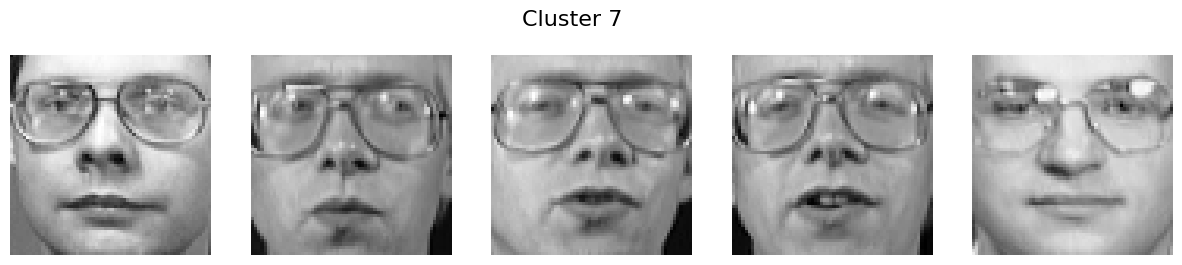

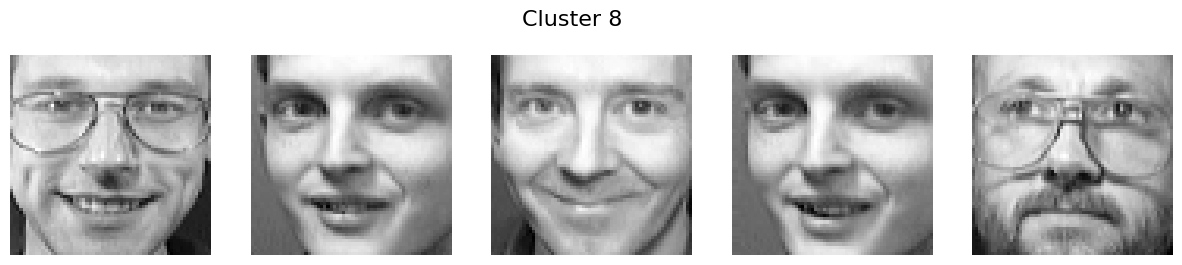

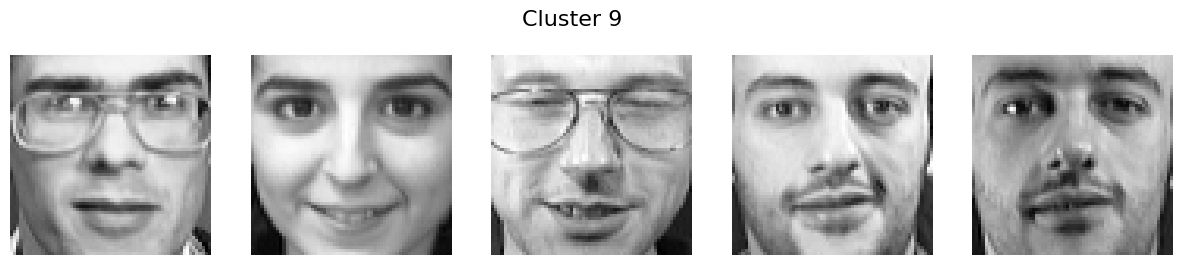

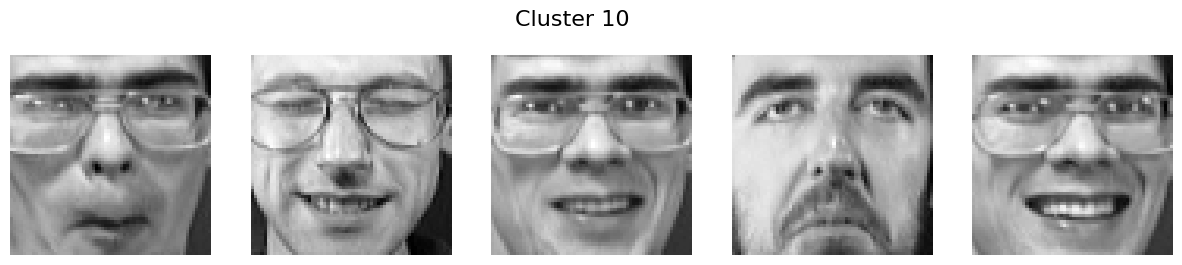

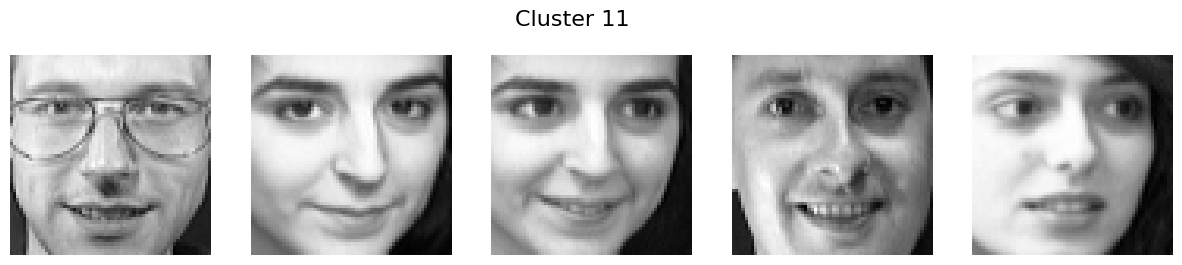

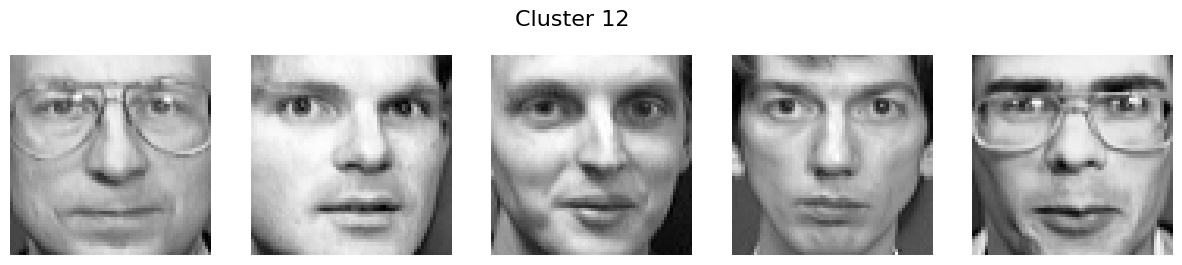

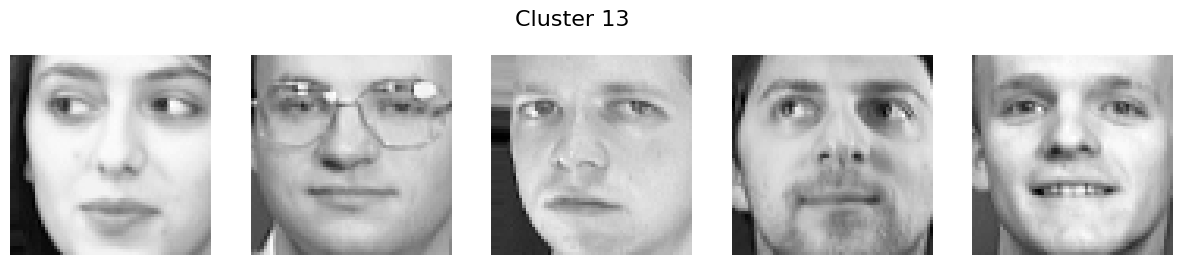

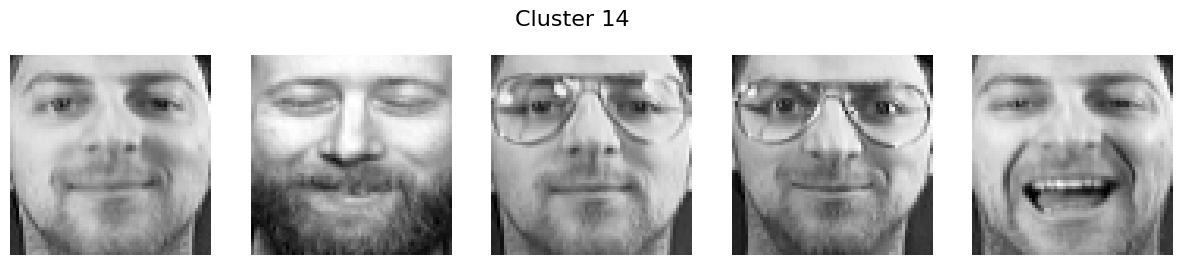

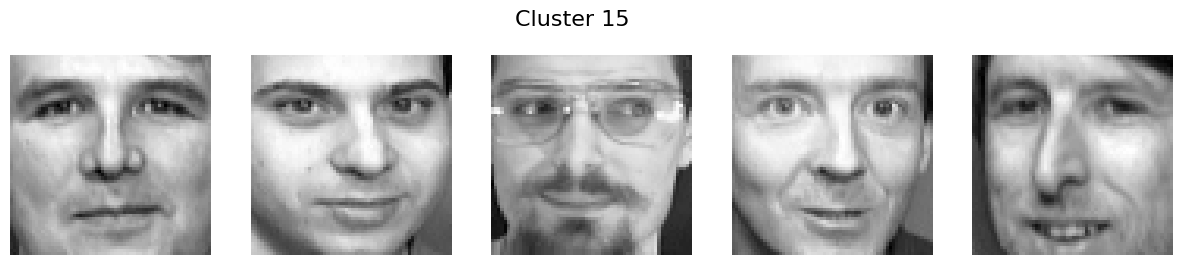

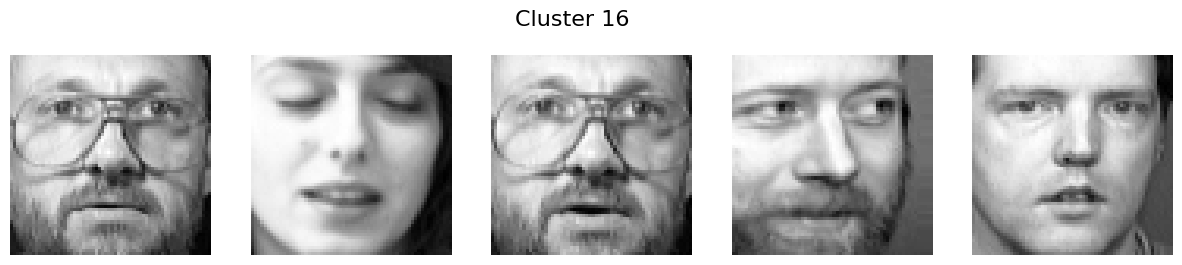

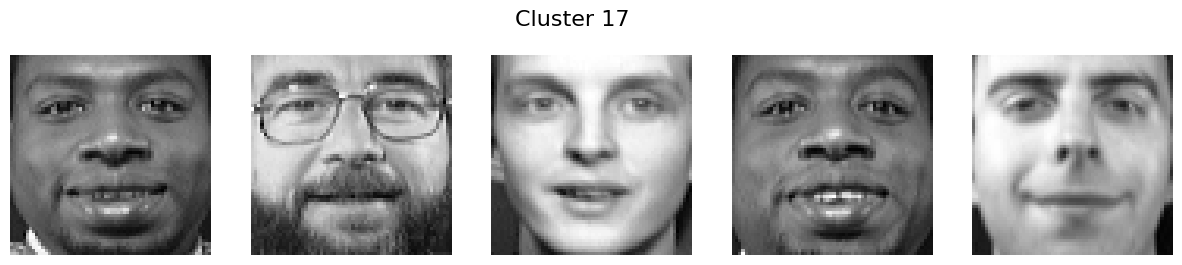

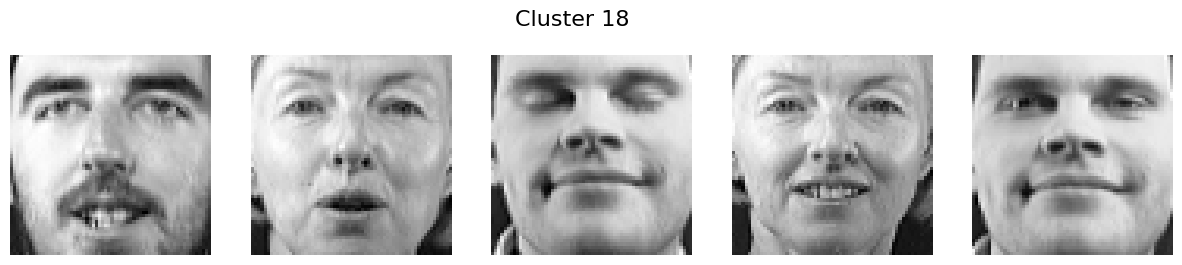

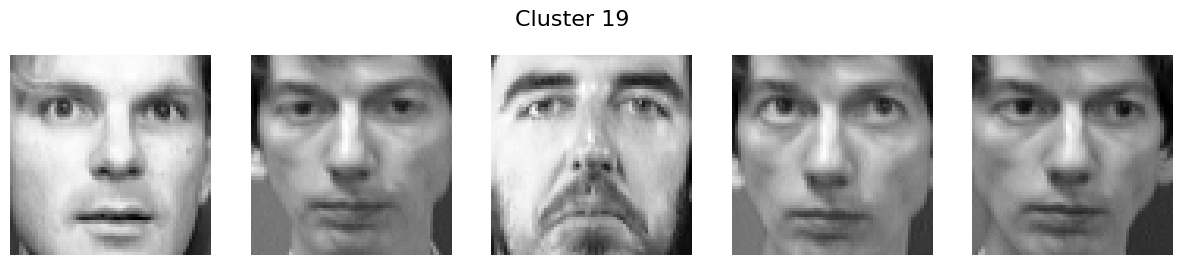

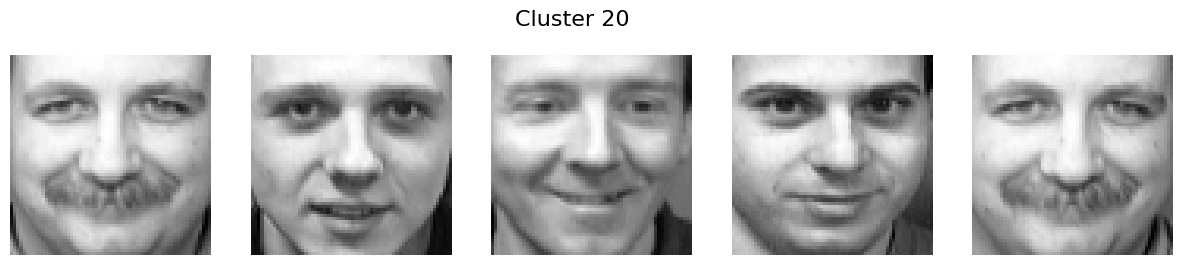

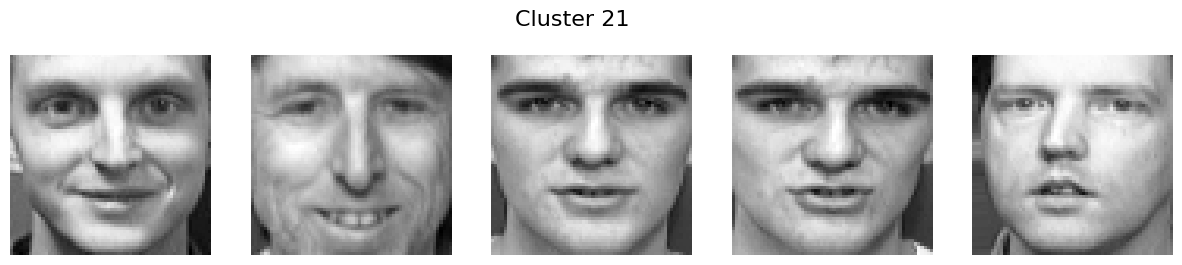

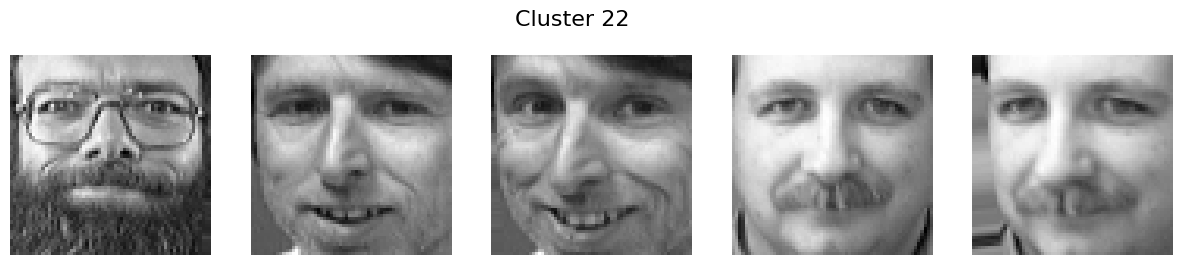

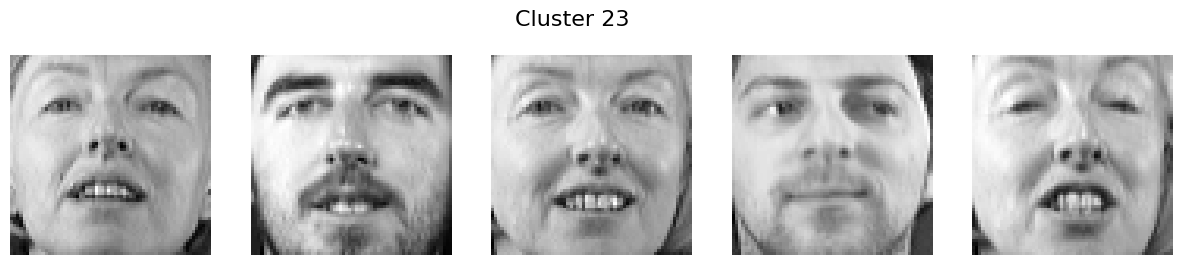

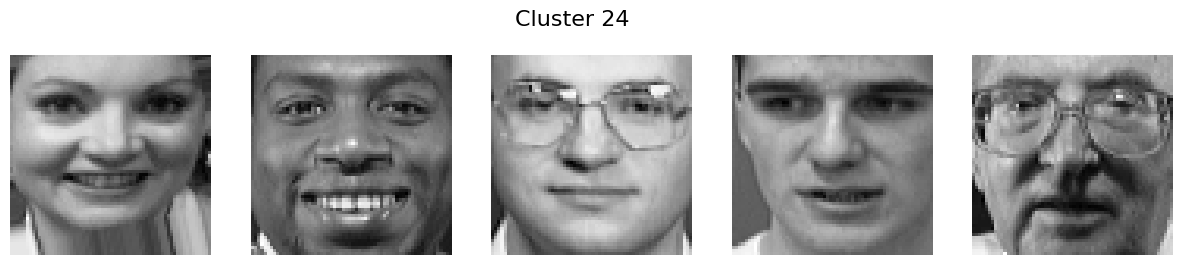

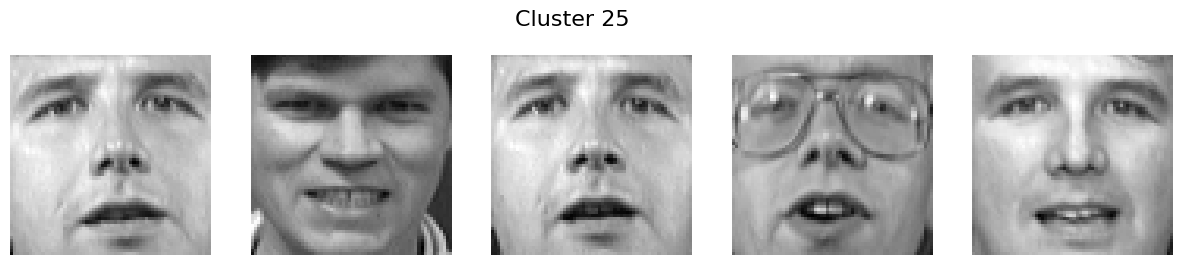

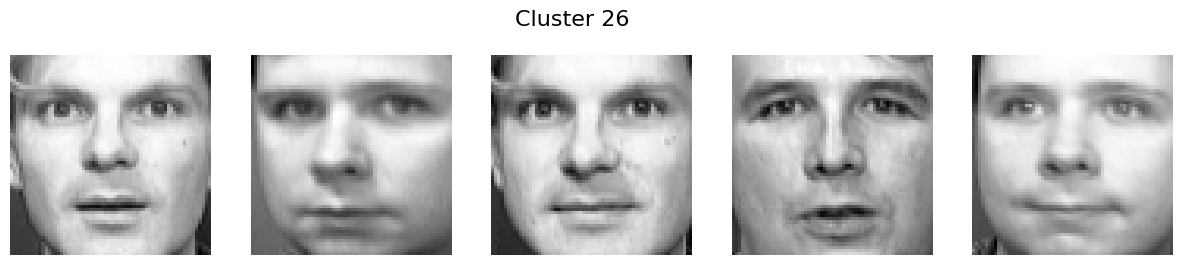

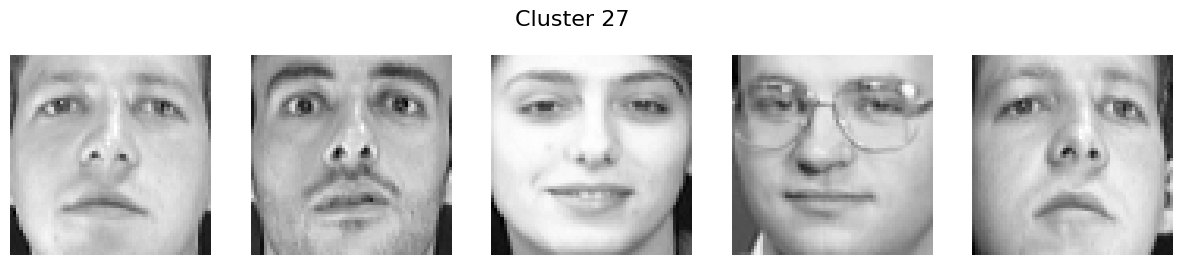

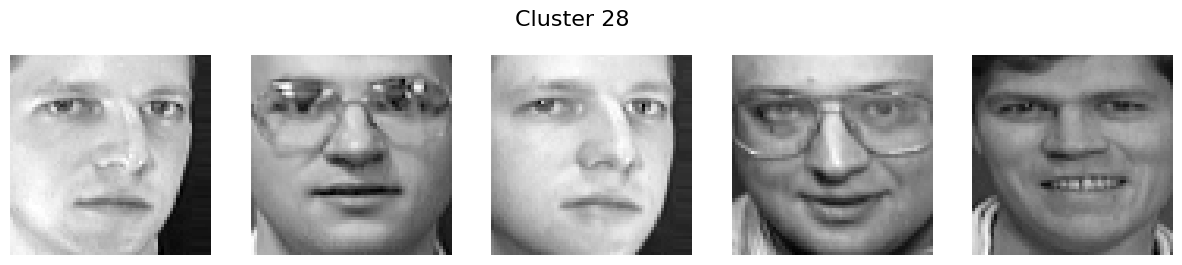

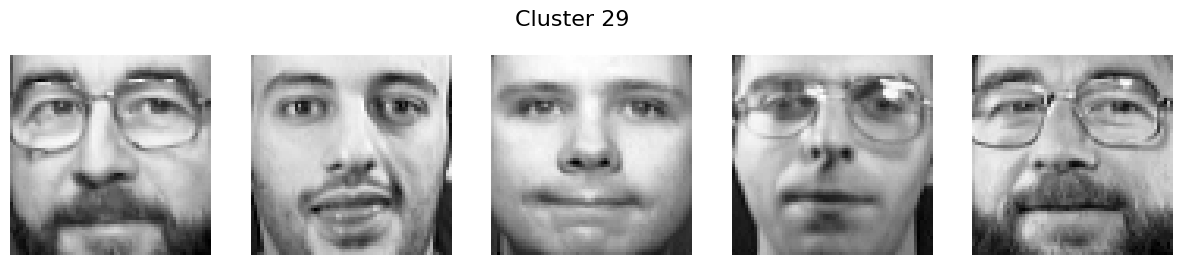

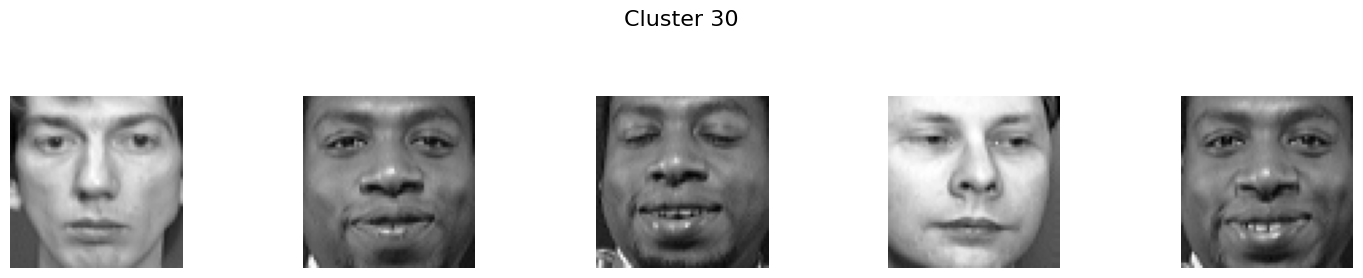

In [48]:
nmf = MYNMF(n_components=30, max_iter=100, epsilon=1e-5, loss="Frobenius", random_state=42)
nmf.fit_transform(faces, mu=best_mu, nu=best_nu, lambd=best_lambda)

D = nmf.D_.copy()
S = nmf.S_.copy()

norms = np.linalg.norm(D, axis=0, keepdims=True) + 1e-12
D /= norms
S *= norms.T

labels_frob = np.argmax(D, axis=1)

for k in range(30):
    example_idx = np.where(labels_frob == k)[0]
    if len(example_idx) > 0:
        fig, axes = plt.subplots(1, min(5,len(example_idx)), figsize=(15, 3))
        axes = axes.ravel()
        for j, ax in enumerate(axes):
          image = faces[example_idx[j], :].reshape((h, w))
          axes[j].imshow(image, cmap='gray')
          axes[j].axis('off')
        fig.suptitle(f"Cluster {k+1}", fontsize=16)
plt.tight_layout()
plt.show()

Cette méthode permet d'effectuer une classification sémantique des images :

Par exemple, le Cluster 2 contient des images de personnes qui regardent la caméra avec un regard similaire.

Le Cluster 7 contient des gens avec une forme de lunettes assez particulière.

Le Cluster 4 contient des personnes avec des visages très similaires.

Le Cluster 12 contient des gens avec des grimaces très semblables.

Ainsi, cette méthode nous permet de réaliser une forme de classification non supervisée des images. Le problème est cependant qu'il est difficile d'interpréter la signification de chaque cluster.

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic.

Discuss.

In [49]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups

n_features = 1000
n_topics = 20
n_top_words = 10

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_feature_indices = topic.argsort()[:-n_top_words - 1:-1]

        top_words = [feature_names[i] for i in top_feature_indices]

        print(f"Topic #{topic_idx:02d}: {' '.join(top_words)}")

print("Loading 20 Newsgroups dataset...")
t0 = time()
data = fetch_20newsgroups(
    shuffle=True,
    random_state=42,
    subset='train',
    remove=('headers', 'footers', 'quotes')
)
data_samples = data.data
print(f"Done in {time() - t0:.3f}s.\n")

print(f"Vectorizing text data (extracting {n_features} features)...")
t0 = time()
vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=n_features,
    stop_words='english'
)
X = vectorizer.fit_transform(data_samples)
feature_names = vectorizer.get_feature_names_out()
print(f"Done in {time() - t0:.3f}s.")
print(f"Matrix shape (n_samples, n_features): {X.shape}\n")

print(f"Fitting NMF model with {n_topics} topics...")
t0 = time()

nmf_model = NMF(
    n_components=n_topics,
    random_state=42,
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5
)
nmf_model.fit(X)
print(f"Done in {time() - t0:.3f}s.\n")

print("Top words per topic:")
print_top_words(nmf_model, feature_names, n_top_words)

Loading 20 Newsgroups dataset...
Done in 1.622s.

Vectorizing text data (extracting 1000 features)...
Done in 2.092s.
Matrix shape (n_samples, n_features): (11314, 1000)

Fitting NMF model with 20 topics...
Done in 17.395s.

Top words per topic:
Topic #00: time don going just know thing really doesn good think
Topic #01: help software windows pc graphics version available computer need use
Topic #02: god believe life true jesus evidence word people christian love
Topic #03: year game team games play home players season guy win
Topic #04: 000 radio research states national years service center university president
Topic #05: thanks mail post information send info email address know group
Topic #06: file program window using files run running windows line code
Topic #07: edu try stuff bike ll hope soon oh just check
Topic #08: key number data chip phone encryption clipper company keys standard
Topic #09: drive hard disk scsi mac apple drives controller cd switch
Topic #10: israel today w

The most common words within each topic give us an approximate idea of what the topic is discussing.

For example, Topic 01 is most likely about the usage of computers and software, while Topic 02 is likely about a religious subject. The problem with this method is that some words aren't very useful for helping us understand the topic, such as "don," "going," and "just."

Therefore, we should choose an appropriate value for n_top_words to properly identify the topic. For example, for Topic 00, we might need to choose a higher value for n_top_words because the topic isn't clear enough with these uninformative words.